In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import solve_ivp
import seaborn as sns
plt.style.use('seaborn-v0_8-poster')

## Implementación de NARMA10 y MSO12

In [36]:
def narma10(n=100):
    y = np.random.rand(n + 10)
    u = np.random.uniform(0, 0.5, n + 10)

    for t in range(10, n + 10 - 1):
        y[t+1] = 0.3 * y[t] + \
               0.05 * y[t] * np.sum(y[t - 10 : t]) + \
               1.5 * u[t - 9] * u[t] + \
               0.1
    return y[10 : n + 10]

# https://www.sciencedirect.com/science/article/pii/S0925231221013333#b0210
def mso12(n=100):
    t = np.arange(n)
    frequencies = [0.2, 0.331, 0.42, 0.51, 0.63, 0.74, 0.85, 0.97, 1.08, 1.19, 1.27, 1.32]
    y = np.sum(np.sin(2 * np.pi * frequencies[i] * t) for i in range(12))

    return y


## Implementación de MG17 con RK4

In [37]:
def dydt(t, y, y_hat, a, b, n):
    return (a * y_hat)/(1 + y_hat**n) + b * y

def solve_MG_System_RK4(a, b, n, tau, t_start, t_end, num_points):
    h = (t_end - t_start) / num_points
    t_values = np.linspace(t_start, t_end, num_points)
    y_values = np.zeros(num_points)

    # Initialize randomly after tau time steps
    y_values[:tau] = np.random.random(tau)

    for i in range(tau, num_points):
        t = t_values[i]
        y_hat = y_values[i - tau]
        y = y_values[i - 1]

        k1 = h * dydt(t, y, y_hat, a, b, n)
        k2 = h * dydt(t + 0.5 * h, y + 0.5 * k1, y_hat, a, b, n)
        k3 = h * dydt(t + 0.5 * h, y + 0.5 * k2, y_hat, a, b, n)
        k4 = h * dydt(t + h, y + k3, y_hat, a, b, n)

        y_values[i] = y + (1/6) * (k1 + 2*k2 + 2*k3 + k4)

    return t_values, y_values

def MGSystem(N=1000):
    # Parameters
    a = 0.2
    b = -0.1
    n = 10
    tau = 17
    t_start = 0
    t_end = N  # Define the upper limit of the time range
    num_points = N

    # Solve the differential equation
    t_values, y_values = solve_MG_System_RK4(a, b, n, tau, t_start, t_end, num_points)

    return y_values


## Funciones para el Algoritmo Adaptativo sad-RC

In [54]:
def make_invertible(matrix, epsilon=1e-6):
    # Add small random perturbations to the diagonal elements
    perturbed_matrix = matrix + epsilon * np.random.randn(*matrix.shape)

    # Ensure the perturbed matrix is invertible
    while np.linalg.matrix_rank(perturbed_matrix) < matrix.shape[0]:
        perturbed_matrix = matrix + epsilon * np.random.randn(*matrix.shape)

    return perturbed_matrix

def generate_K_matrix(n, rho, sparsity=0.95, rho_threshold=1e-5):
    # generate a random matrix with desired sparsity and range of values
    M = np.random.uniform(-1, 1, (n, n))
    
    flattened_matrix = M.flatten()
    # Calculate the number of elements to set as zero
    num_elements = len(flattened_matrix)
    num_zero_elements = int(sparsity * num_elements)
    # Randomly select indices to set as zero
    zero_indices = np.random.choice(num_elements, num_zero_elements, replace=False)
    # Set the selected indices as zero in the flattened matrix
    flattened_matrix[zero_indices] = 0
    # Reshape the flattened matrix back to the original shape
    M = flattened_matrix.reshape(M.shape)

    return M

def rescale_spectral_radius(M, rho, rho_threshold=1e-5):
    # compute the current spectral radius of M
    eigvals = np.linalg.eigvals(M)
    current_rho = np.max(np.abs(eigvals))
    # ensure that current_rho is not zero
    if current_rho < rho_threshold:
        M = make_invertible(M)
        eigvals = np.linalg.eigvals(M)
        current_rho = np.max(np.abs(eigvals))

    # scale M to achieve the desired spectral radius
    M = M * (rho / current_rho)

    return M

def generate_W_matrix(n):
    # set the random seed for reproducibility
    #np.random.seed(42)

    # generate an array of 100 numbers with mean=0 and std=1
    W = np.random.randn(n)

    return W

def univariate_ridge_regression(theta, y, alpha=1e-2):
    # compute the weight matrix using ridge regression
    X = np.reshape(theta, (1, -1))
    Y = np.array([[y]])
    I = np.identity(X.shape[1])
    try:
        W_out = np.linalg.inv(X.T @ X + alpha * I) @ X.T @ Y
    except np.linalg.LinAlgError:
        # if the matrix is singular, increase alpha and try again
        alpha *= 10
        try:
            W_out = np.linalg.inv(X.T @ X + alpha * I) @ X.T @ Y
        except np.linalg.LinAlgError:
            alpha *= 10
            W_out = np.linalg.inv(X.T @ X + alpha * I) @ X.T @ Y

    return W_out

def kuramoto_synchrony(phases):
    N = len(phases)
    R = np.mean(np.exp(1j * phases))
    r = np.abs(R)
    return r

def MSE(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

def memory_capacity(y, k=100):
    s = np.random.uniform(-0.5, 0.5, size=len(y))
    s_shifted = np.roll(s, -k)  # Shift s(t) by k positions

    cov = np.cov(s_shifted, y)[0, 1]  # Calculate covariance between s(t-k) and y(t)
    var_s = np.var(s)  # Calculate variance of s(t)
    var_y = np.var(y)  # Calculate variance of y(t)

    memory_capacity = cov ** 2 / (var_s * var_y)
    return memory_capacity

## Gráficas de ejemplo de las series de tiempo implementadas

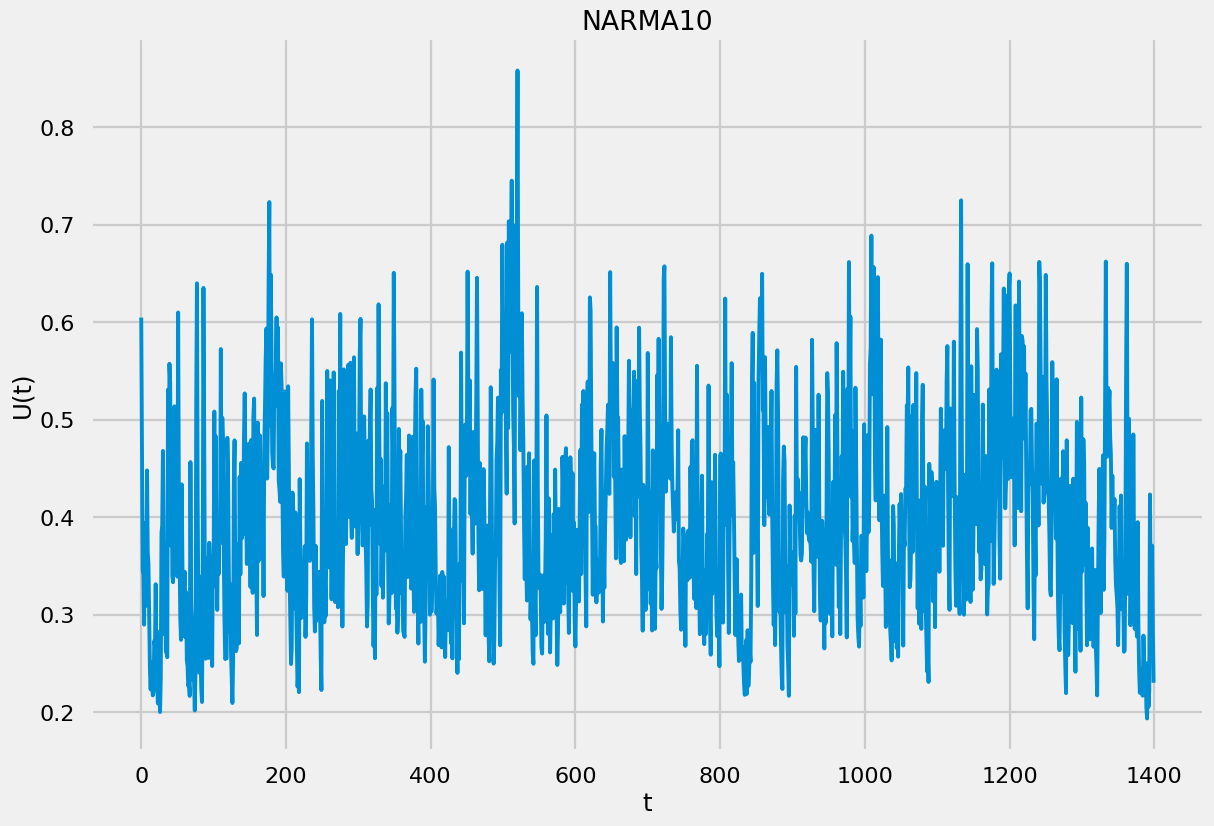

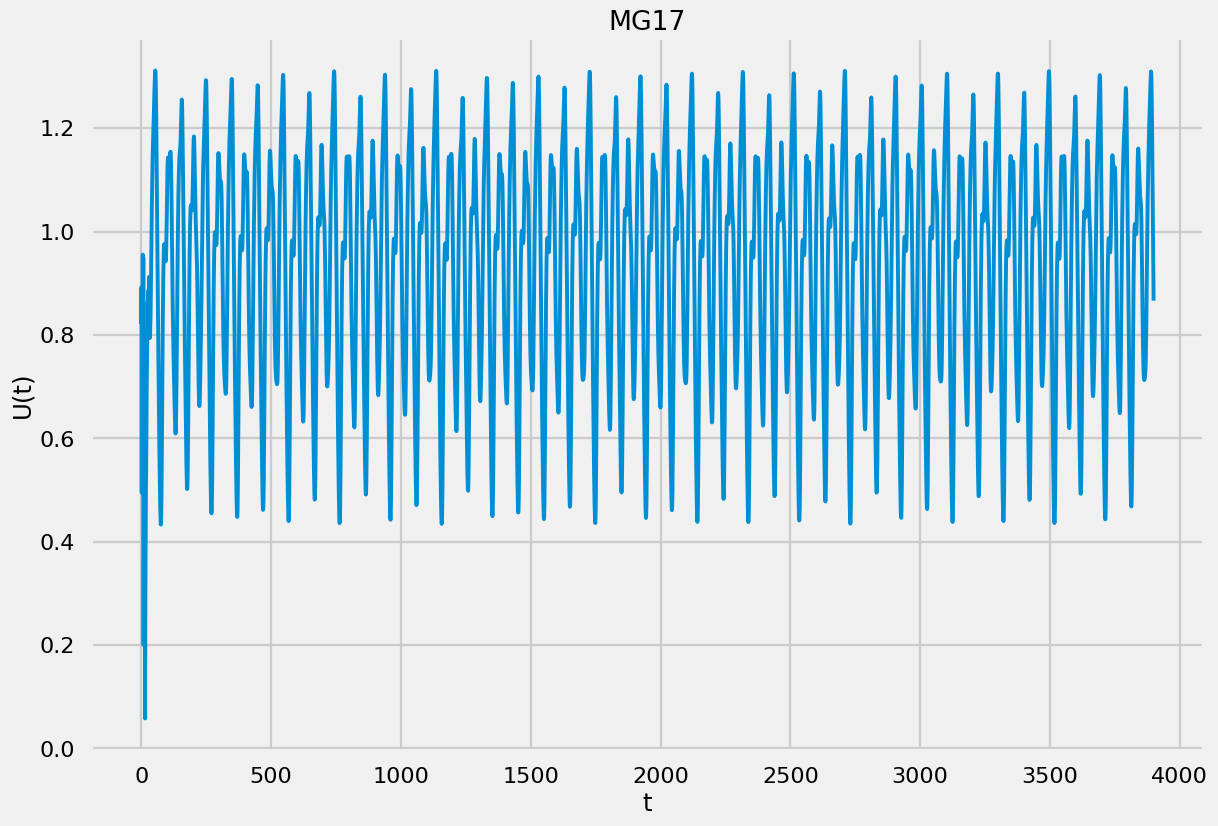

<ipython-input-36-86a2a31f90df>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y = np.sum(np.sin(2 * np.pi * frequencies[i] * t) for i in range(12))


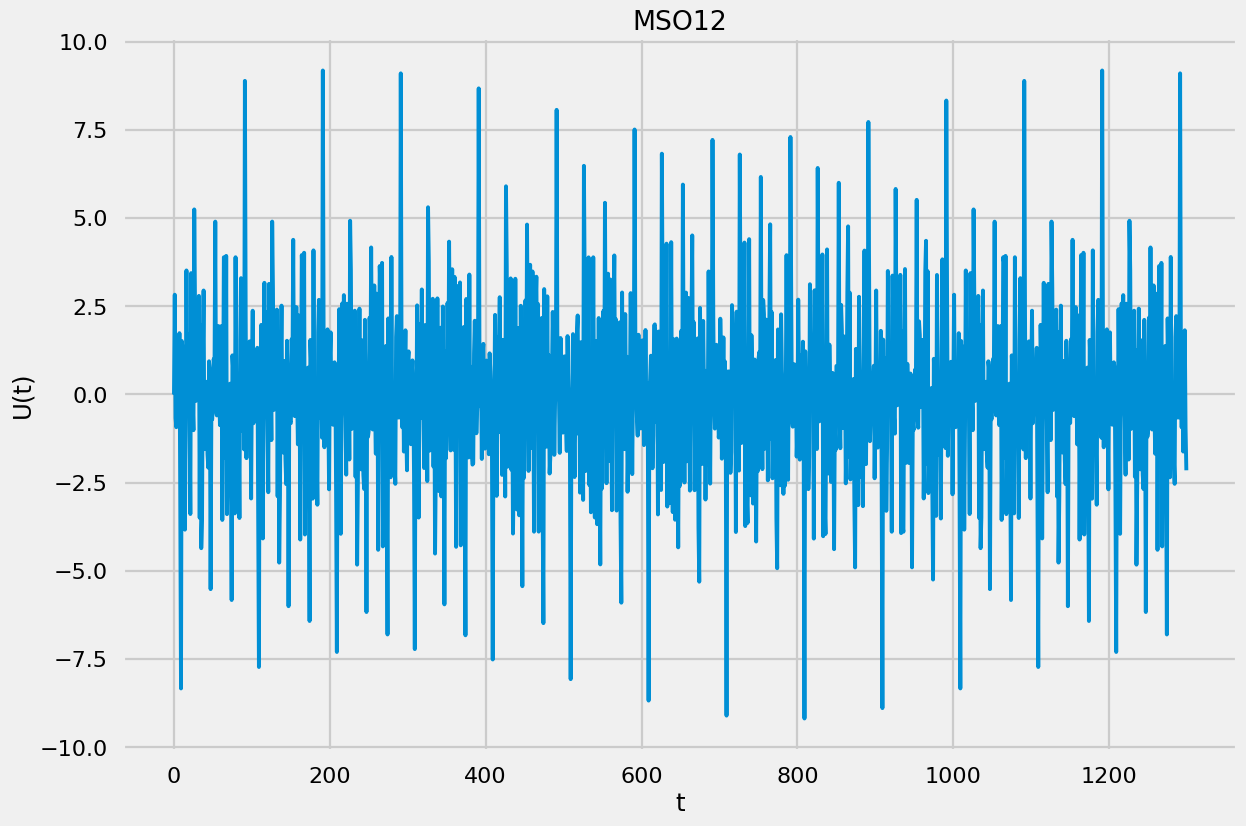

In [55]:
n = 1400
U = narma10(n)

plt.plot(range(n), U)
plt.xlabel('t')
plt.ylabel('U(t)')
plt.title('NARMA10')
plt.show()

n = 3900
U = MGSystem(n)

plt.plot(range(n), U)
plt.xlabel('t')
plt.ylabel('U(t)')
plt.title('MG17')
plt.show()

n = 1300
U = mso12(n)

plt.plot(range(n), U)
plt.xlabel('t')
plt.ylabel('U(t)')
plt.title('MSO12')
plt.show()

## Más Funciones para el Algoritmo Adaptativo sad-RC

In [56]:
h = 1.0
eps = 0.1

def f(t, THETA, T, W, L, K): # T is the actual time in the time series
    result = []
    for i in range(N):
        val = W[i] + L * sum(K[i][j] * np.sin(THETA[j] - THETA[i] + U[int(T)]) for j in range(N))
        result.append(val)
    return np.array(result)

def bound(x):
    if x > 1:
        return 1
    if x < -1:
        return -1
    return x

def bound_matrix(M):
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            M[i, j] = bound(M[i, j])
    return M

def g(t, theta, i, j, B):
    Kij = -eps * np.sin(theta[j] - theta[i] + B)
    return Kij

def Euler_iteration(t, W, L, THETA, K):
    THETA[:, t] = THETA[:, t-1] + h * f(t-1, THETA[:, t-1], t, W, L, K)
    return THETA

def Euler_matrix_iteration(t, K, THETA, B):
    for i in range(N):
        for j in range(N):
            K[i][j] = K[i][j] + h * g(t, THETA[:, t], i, j, B)
    K = bound_matrix(K)
    return K

def train(U, K, rho, THETA, W, L, a, b, B):
    for t, u in zip(range(1, b + 1), U[1:b + 1]):
        THETA = Euler_iteration(t, W, L, THETA, K)
        if t <= a:
            K = Euler_matrix_iteration(t, K, THETA, B)
            K = rescale_spectral_radius(K, rho)
    W_out = univariate_ridge_regression(THETA[:, b], U[b])
    Y = []
    for t, u in zip(range(b + 1, n), U[b + 1:n]):
        THETA = Euler_iteration(t, W, L, THETA, K)
        y = W_out.T @ THETA[:, t] 
        Y.append(y[0])
        W_out = univariate_ridge_regression(THETA[:, t], U[t])

    return Y, THETA, K


## Experimento con parámetros fijos para NARMA10

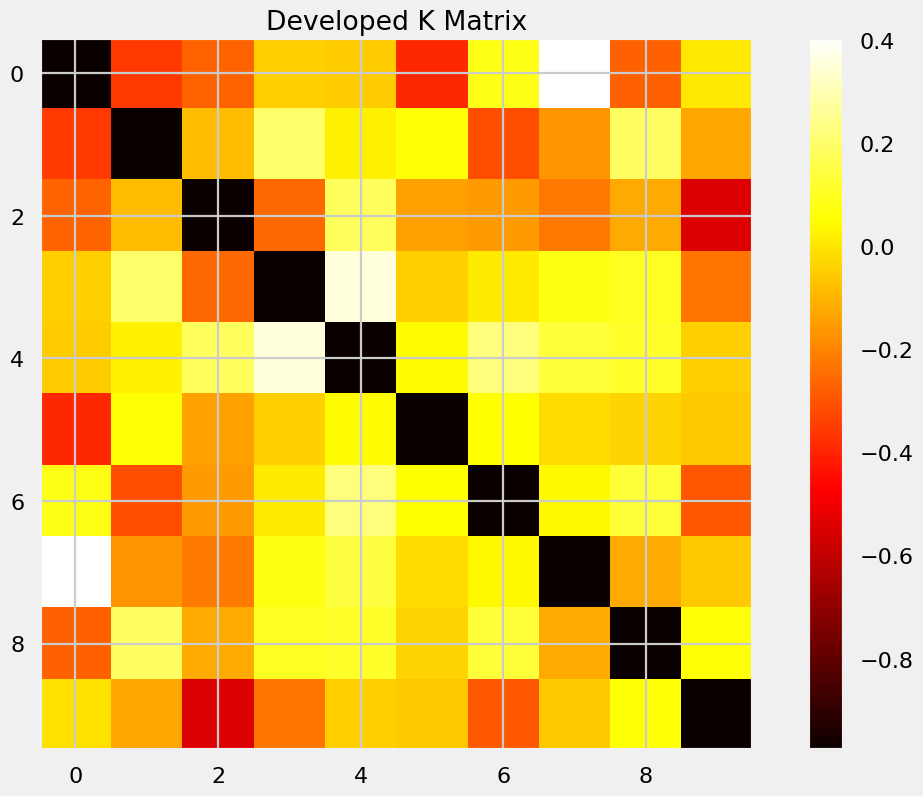

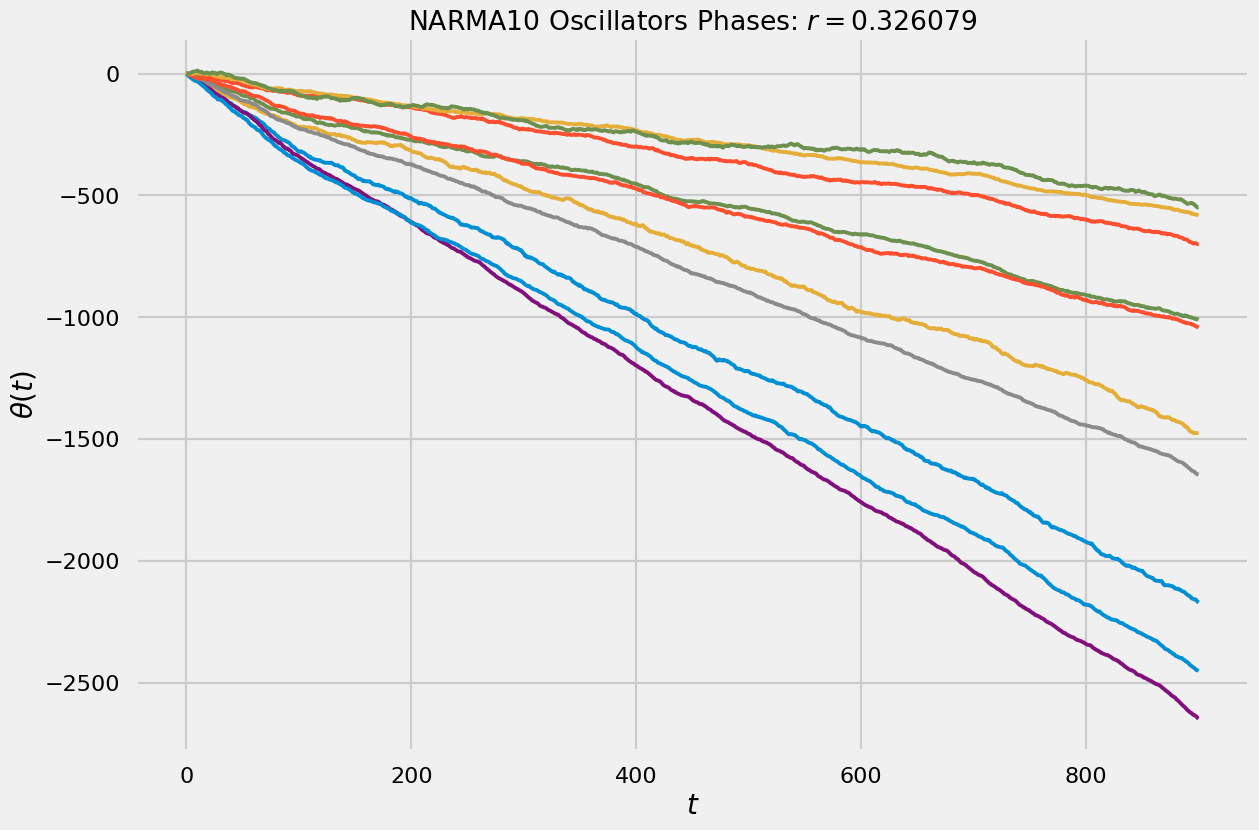

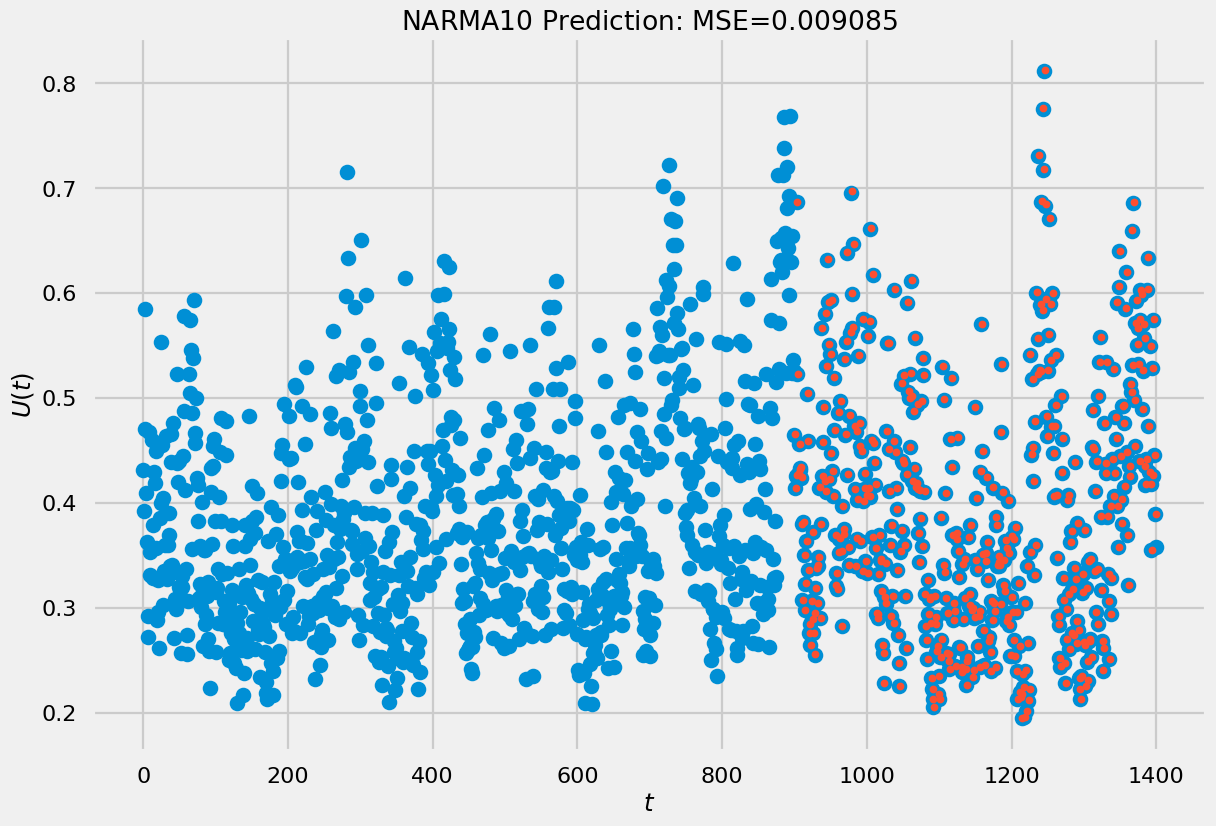

MSE: 0.009084563988690453
Synchrony: 0.3260787625884166


In [69]:
n = 1400
U = narma10(n)
a = 100
b = 900
N = 10
rho = 2.0
sparsity = 0.95 # density is 0.05
K = generate_K_matrix(N, rho, sparsity)
W = generate_W_matrix(N)
B = np.pi / 2
L = 4.0

THETA = np.zeros((N, n))
Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)

plt.imshow(K, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Developed K Matrix')
plt.show()

'''
plt.imshow(THETA[:, :50], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Oscillators Phases Heatmap')
plt.show()
'''

r = kuramoto_synchrony(THETA[:, -1])
mse = MSE(U[b + 1:], Y)

for i in range(N):
    plt.plot(range(b + 1), THETA[i, :b + 1], '-')
plt.xlabel(r'$t$', size=20)
plt.ylabel(r'$\theta(t)$', size=20)
plt.title(f'NARMA10 Oscillators Phases: $r={r:.6f}$')
plt.show()

plt.plot(np.array(range(n)), U, 'o')
plt.plot(np.array(range(b + 1, n)), np.array(Y), '.')
plt.xlabel('$t$')
plt.ylabel('$U(t)$')
plt.title(f'NARMA10 Prediction: MSE=${mse:.6f}$')
plt.show()

print('MSE:', mse)
print('Synchrony:', r)


## Experimento con parámetros fijos para MG17

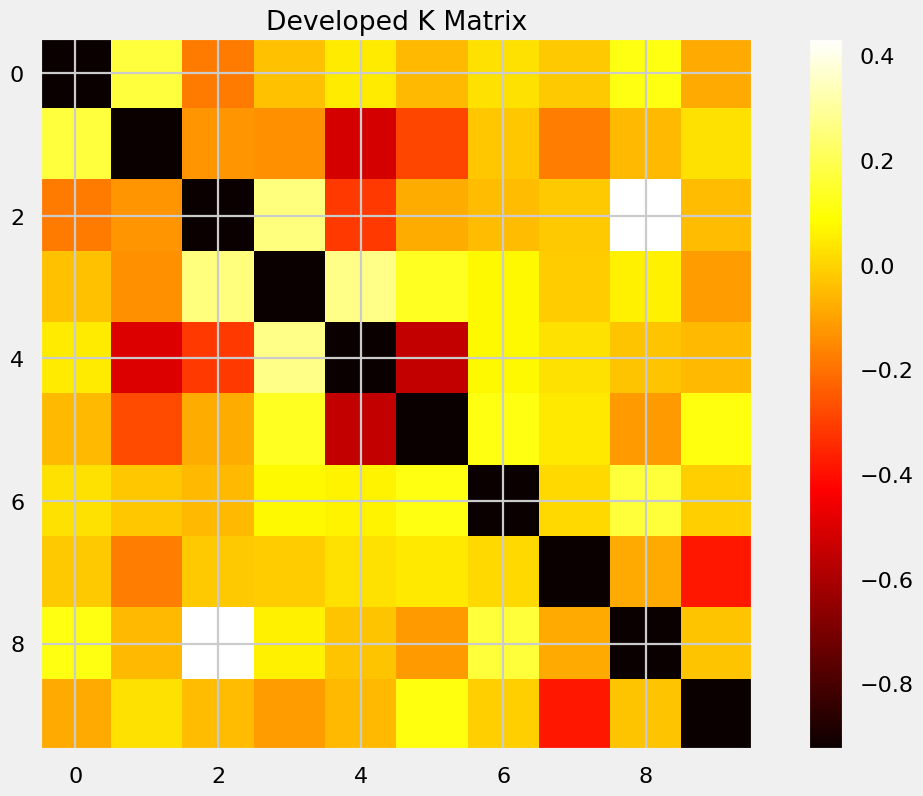

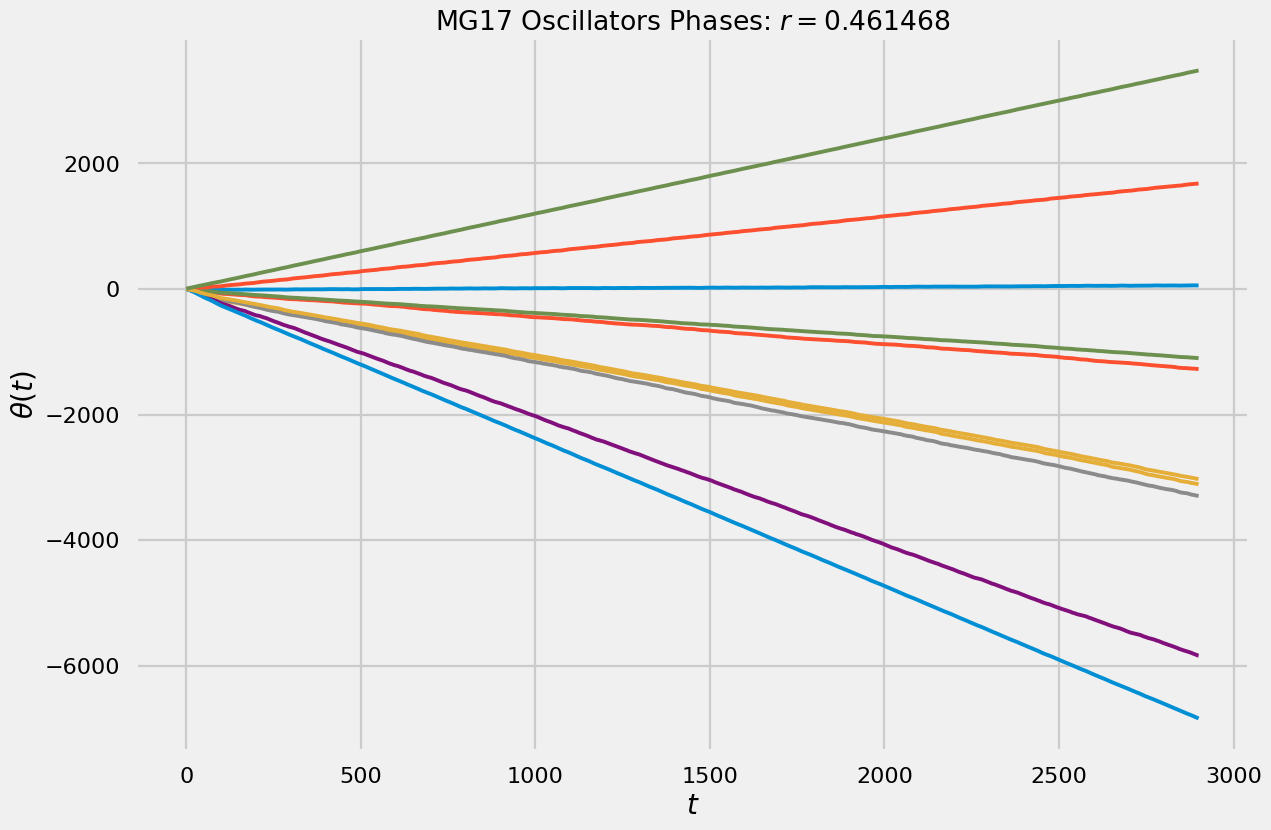

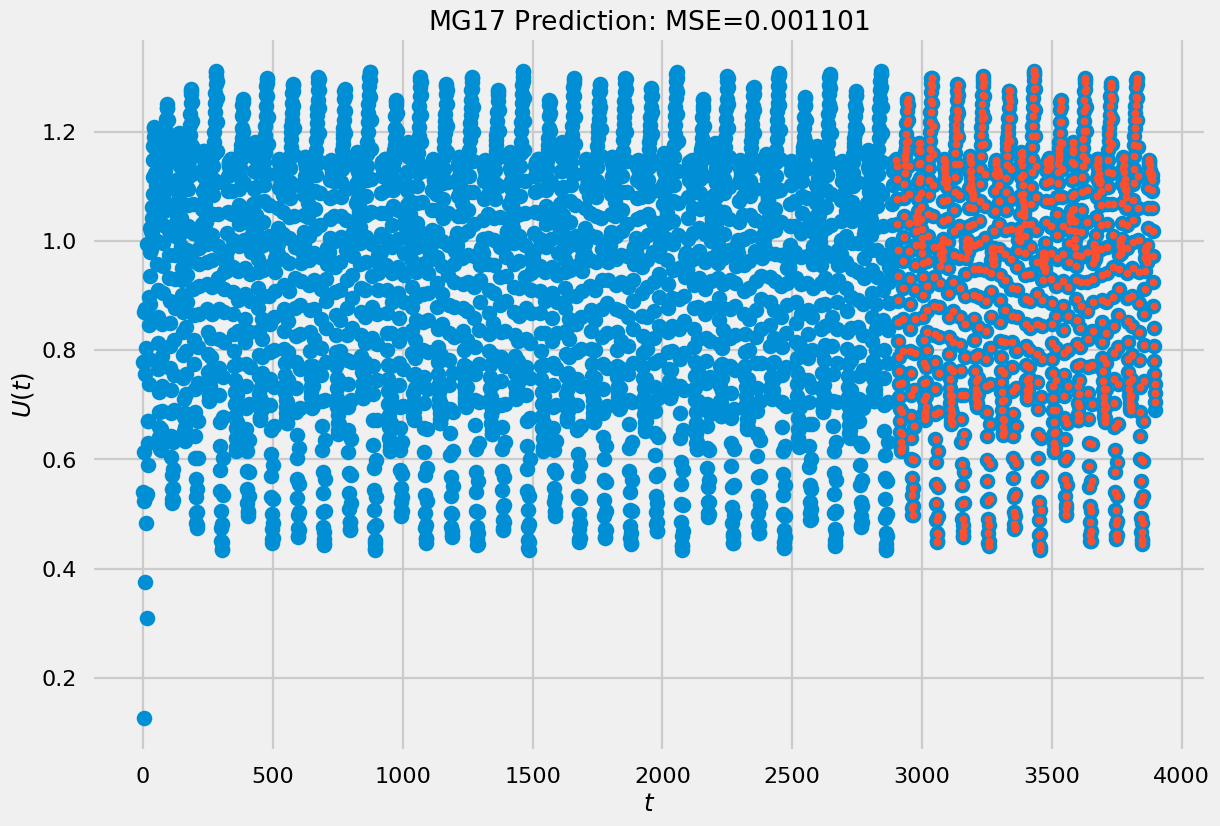

MSE: 0.0011008200728191246
Synchrony: 0.46146849833008907


In [88]:
n = 3900
U = MGSystem(n)
a = 100
b = 2900
N = 10
rho = 2.0
sparsity = 0.95 # density is 0.05
K = generate_K_matrix(N, rho, sparsity)
W = generate_W_matrix(N)
B = np.pi / 2
L = 1.0

THETA = np.zeros((N, n))
Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)

plt.imshow(K, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Developed K Matrix')
plt.show()

r = kuramoto_synchrony(THETA[:, -1])
mse = MSE(U[b + 1:], Y)

for i in range(N):
    plt.plot(range(b + 1), THETA[i, :b + 1], '-')
plt.xlabel(r'$t$', size=20)
plt.ylabel(r'$\theta(t)$', size=20)
plt.title(f'MG17 Oscillators Phases: $r={r:.6f}$')
plt.show()

plt.plot(np.array(range(n)), U, 'o')
plt.plot(np.array(range(b + 1, n)), np.array(Y), '.')
plt.xlabel('$t$')
plt.ylabel('$U(t)$')
plt.title(f'MG17 Prediction: MSE=${mse:.6f}$')
plt.show()

print('MSE:', mse)
print('Synchrony:', r)


## Experimento con parámetros fijos para MSO12

<ipython-input-36-86a2a31f90df>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y = np.sum(np.sin(2 * np.pi * frequencies[i] * t) for i in range(12))


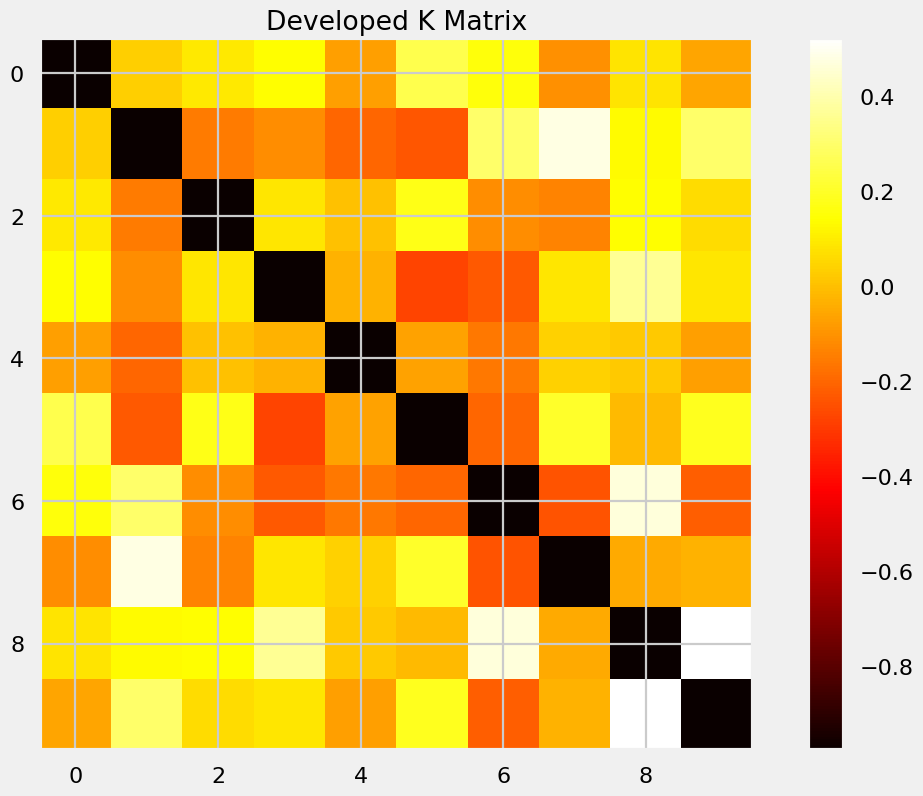

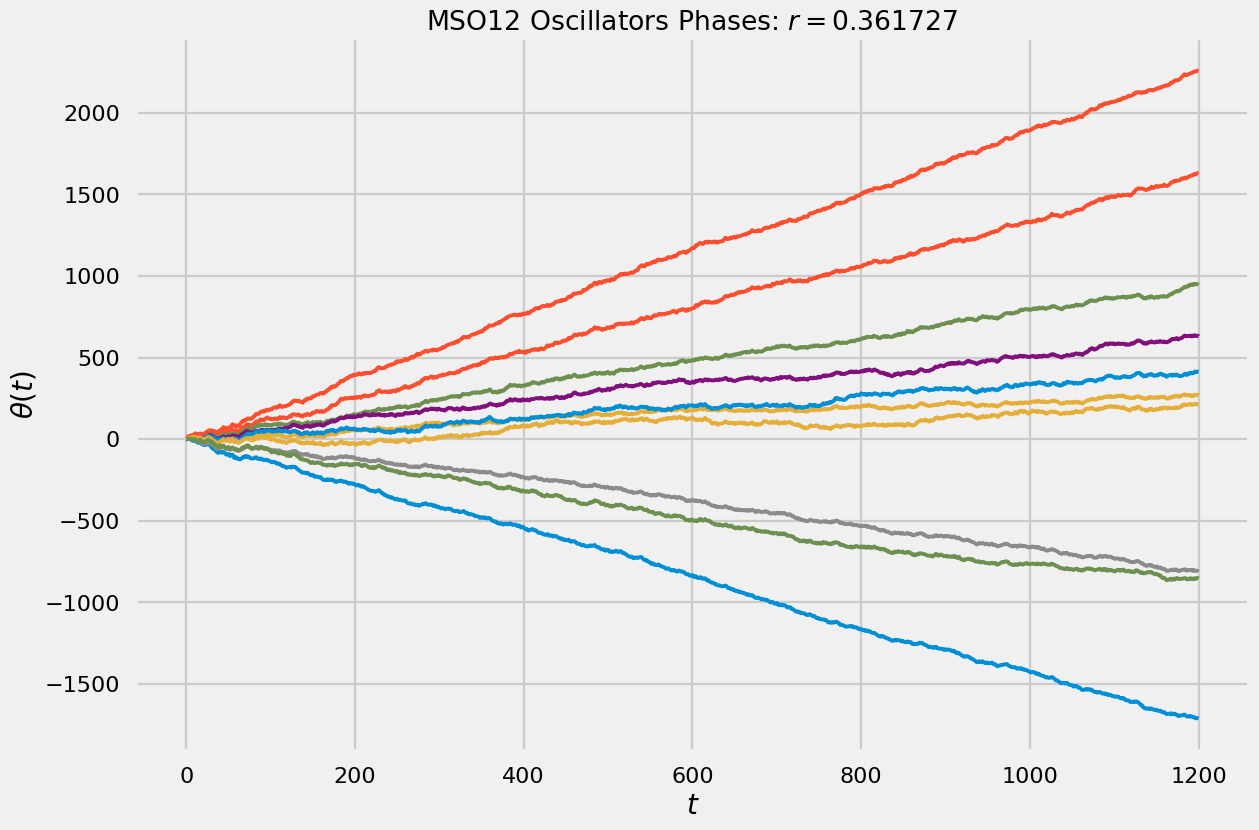

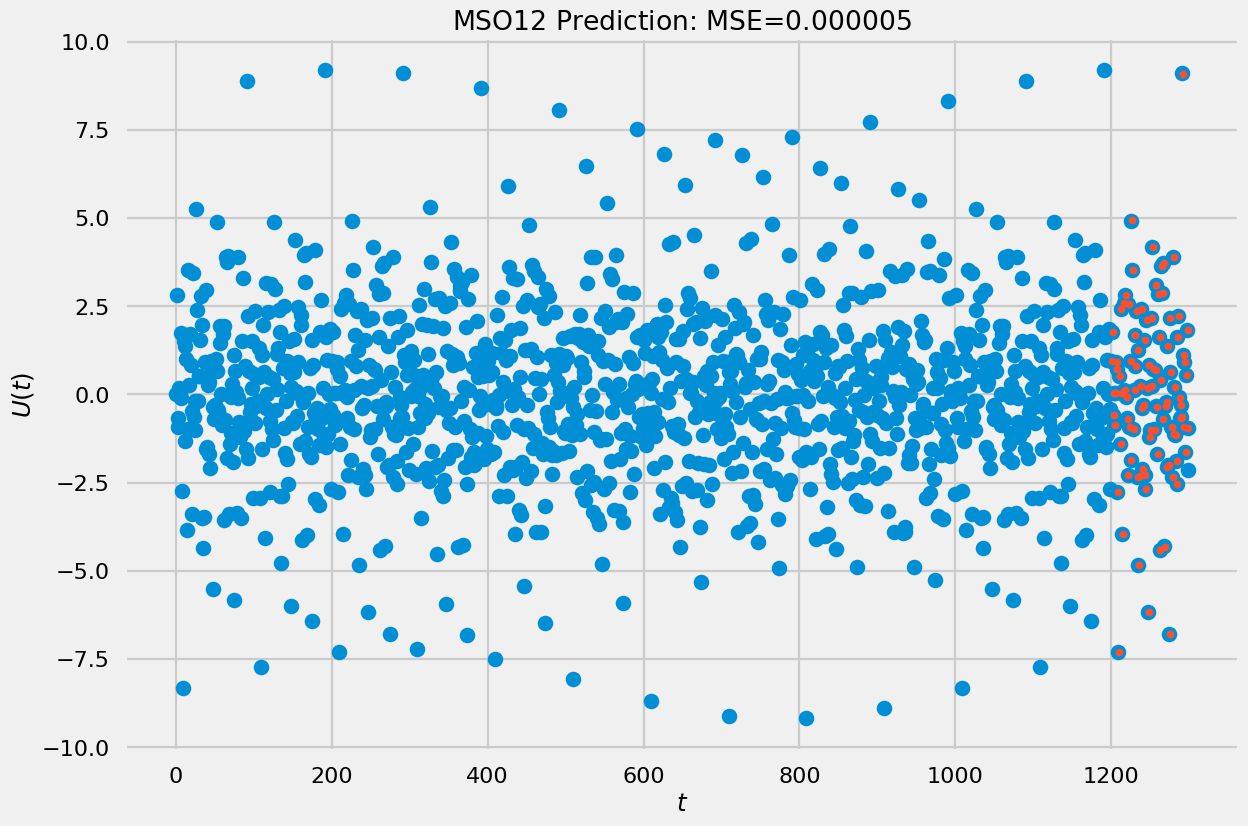

MSE: 4.793336426484713e-06
Synchrony: 0.361727211227752


In [94]:
n = 1300
U = mso12(n)
a = 100
b = 1200
N = 10
rho = 2.0
sparsity = 0.95 # density is 0.05
K = generate_K_matrix(N, rho, sparsity)
W = generate_W_matrix(N)
B = np.pi / 2
L = 4.0

THETA = np.zeros((N, n))
Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)

plt.imshow(K, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Developed K Matrix')
plt.show()

r = kuramoto_synchrony(THETA[:, -1])
mse = MSE(U[b + 1:-1], Y[1:])

for i in range(N):
    plt.plot(range(b + 1), THETA[i, :b + 1], '-')
plt.xlabel(r'$t$', size=20)
plt.ylabel(r'$\theta(t)$', size=20)
plt.title(f'MSO12 Oscillators Phases: $r={r:.6f}$')
plt.show()

plt.plot(np.array(range(n)), U, 'o')
plt.plot(np.array(range(b + 1, n)), np.array(Y), '.')
plt.xlabel('$t$')
plt.ylabel('$U(t)$')
plt.title(f'MSO12 Prediction: MSE=${mse:.6f}$')
plt.show()

print('MSE:', mse)
print('Synchrony:', r)


## Variación de radio espectral y fuerza de acoplamiento para NARMA10

0 0 0
MSE: 0.008258605439162483
r: 0.29819345476557696
0 1 0
MSE: 0.01004136675907591
r: 0.5166734143297238
0 2 0
MSE: 0.008482255708535412
r: 0.31771541546446125
0 3 0
MSE: 0.007853985946454365
r: 0.5737758302048525
0 4 0
MSE: 0.007661845521934149
r: 0.2931043797346683
0 5 0
MSE: 0.009610083250713039
r: 0.3045667230398301
0 6 0
MSE: 0.008360563405304269
r: 0.29395582121579694
0 7 0
MSE: 0.009613272181966446
r: 0.3702788077404903
0 8 0
MSE: 0.009177336812151493
r: 0.07737347185803709
0 9 0
MSE: 0.009128358540890768
r: 0.47949443588404805
1 0 0
MSE: 0.009092842023090008
r: 0.2630017371060073
1 1 0
MSE: 0.009426887259814908
r: 0.4998111279156291
1 2 0
MSE: 0.00813411356010595
r: 0.24815916290764703
1 3 0
MSE: 0.00891813115086021
r: 0.2261113507638666
1 4 0
MSE: 0.009196606381663497
r: 0.07550584149096692
1 5 0
MSE: 0.008472010967299024
r: 0.26950190840123917
1 6 0
MSE: 0.009578824184044389
r: 0.12339930623679542
1 7 0
MSE: 0.008372654676646784
r: 0.41413298211614435
1 8 0
MSE: 0.00977898

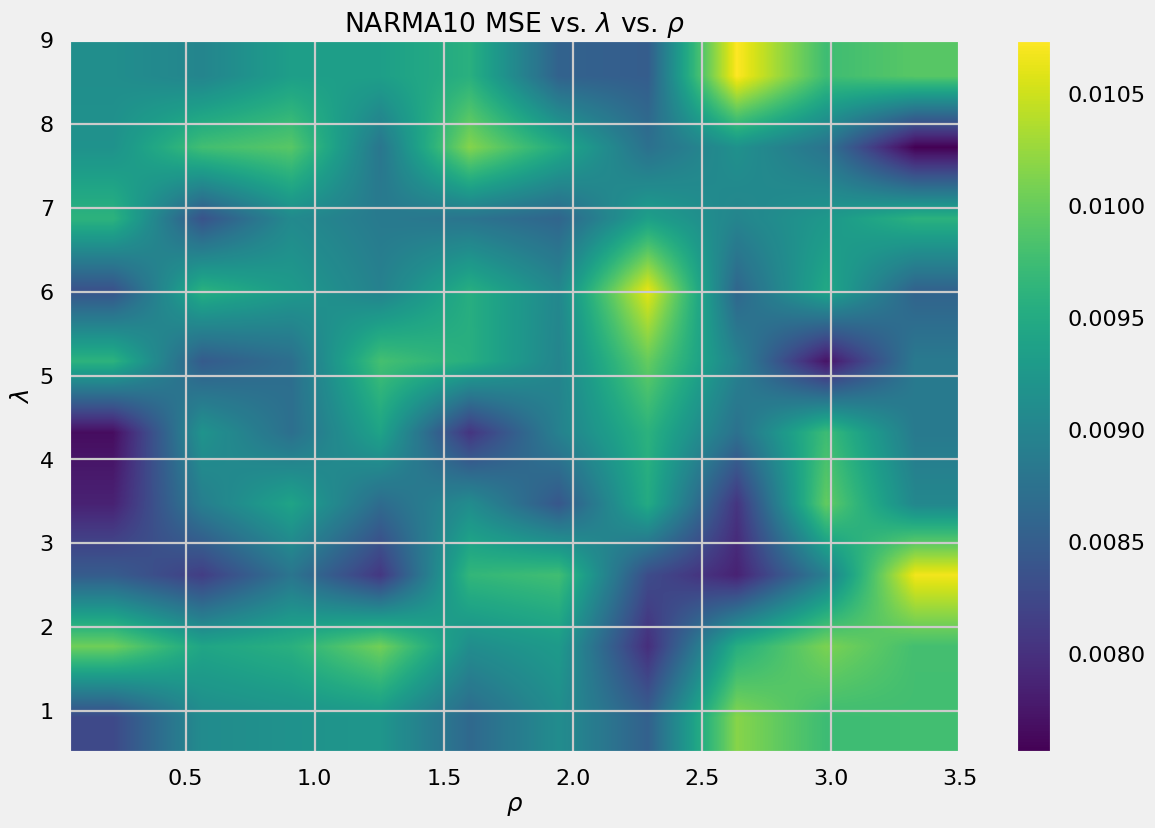

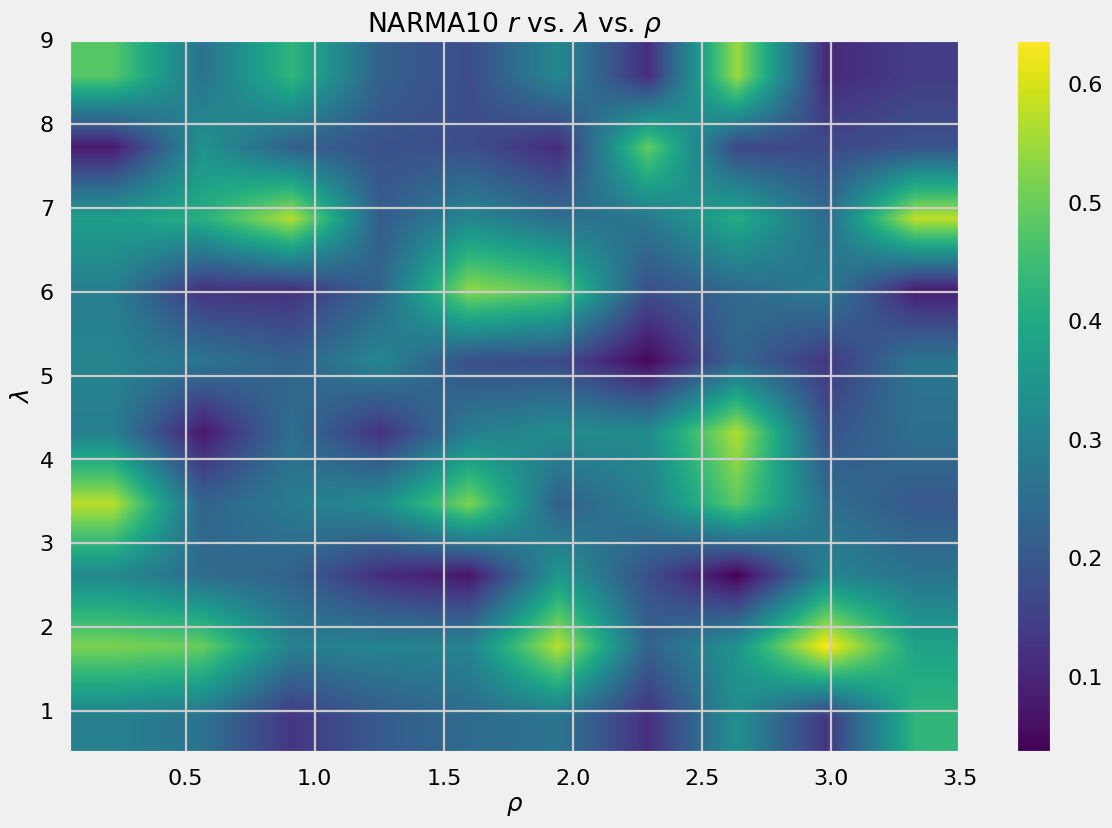

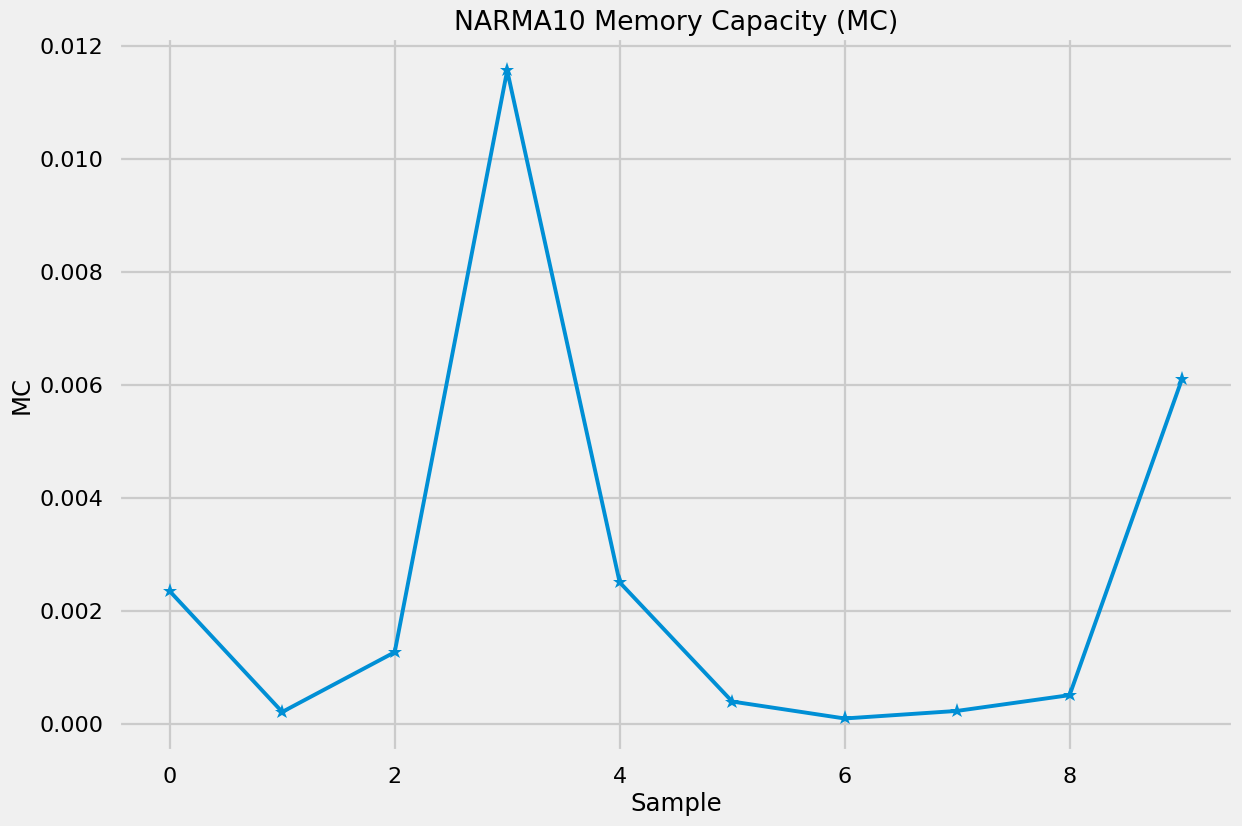

In [81]:
# Define the range of rho and L values to use
rhos = np.linspace(0.05, 3.5, 10)
Ls = np.linspace(0.5, 9, 10)

sparsity = 0.95

# Define the number of iterations to use
num_iterations = 1

# Initialize arrays to store the average MSE values
mse_values = np.zeros((len(rhos), len(Ls)))
r_values = np.zeros((len(rhos), len(Ls)))
mc_values = []

n = 1400
a = 100
b = 900

N = 10

sparsity = 0.05

# Loop over all combinations of rho and L values
for i, rho in enumerate(rhos):
    for j, L in enumerate(Ls):
        
        # Initialize the mean squared error to zero
        mse = 0
        r = 0
        
        # Perform multiple iterations and average the results
        for k in range(num_iterations):

            print(i, j, k)
            
            # Initialize the input sequence and network parameters
            U = narma10(n)
            K = generate_K_matrix(N, rho, sparsity)
            W = generate_W_matrix(N)
            THETA = np.zeros((N, n))
            
            # Train the network and compute the mean squared error
            Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
            mse += MSE(U[b + 1:], Y)
            r += kuramoto_synchrony(THETA[:, -1])
        
        mse /= num_iterations
        print('MSE:', mse)
        r /= num_iterations
        print('r:', r)

        # Store the mean squared error in the array
        mse_values[i, j] = mse
        r_values[i, j] = r
    
    mc = memory_capacity(Y)
    mc_values.append(mc)

# Create a contour plot of the average error as a function of rho and L
X, Y = np.meshgrid(rhos, Ls)
plt.imshow(mse_values.T, extent=[np.min(rhos), np.max(rhos), np.min(Ls), np.max(Ls)], origin='lower', aspect='auto', interpolation='bilinear')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\lambda$')
plt.title(r'NARMA10 MSE vs. $\lambda$ vs. $\rho$')
plt.colorbar()
plt.show()

X, Y = np.meshgrid(rhos, Ls)
plt.imshow(r_values.T, extent=[np.min(rhos), np.max(rhos), np.min(Ls), np.max(Ls)], origin='lower', aspect='auto', interpolation='bilinear')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\lambda$')
plt.title(r'NARMA10 $r$ vs. $\lambda$ vs. $\rho$')
plt.colorbar()
plt.show()

plt.plot(range(10), mc_values, '*-')
plt.xlabel('Sample')
plt.ylabel('MC')
plt.title('NARMA10 Memory Capacity (MC)')
plt.show()

## Variación de radio espectral y fuerza de acoplamiento para MG17

0 0 0
MSE: 0.001099812595248844
r: 0.32817415397324823
0 1 0
MSE: 0.0011211057611596484
r: 0.3515360698694003
0 2 0
MSE: 0.0010956264909337628
r: 0.21734141181065703
0 3 0
MSE: 0.0011120910748344862
r: 0.12817278228405823
0 4 0
MSE: 0.0011063122982646896
r: 0.128199435880626
0 5 0
MSE: 0.0011072460638608204
r: 0.01676212919184586
0 6 0
MSE: 0.0011157590881322314
r: 0.3815323087833841
0 7 0
MSE: 0.0011175595596462566
r: 0.45015677871748216
0 8 0
MSE: 0.001086983267961534
r: 0.328831832248257
0 9 0
MSE: 0.0011051279387797187
r: 0.22753560272127044
1 0 0
MSE: 0.00110976162289955
r: 0.404292445896673
1 1 0
MSE: 0.0010998230483122852
r: 0.062077706164323926
1 2 0
MSE: 0.0010968215185097462
r: 0.17941750021295724
1 3 0
MSE: 0.001115865494516007
r: 0.13409006495697734
1 4 0
MSE: 0.0010986099412319016
r: 0.3130354272333491
1 5 0
MSE: 0.001110815216030331
r: 0.13969252411239652
1 6 0
MSE: 0.0010910642566896336
r: 0.249110823175459
1 7 0
MSE: 0.0011039888559327632
r: 0.33234362450909183
1 8 0
MS

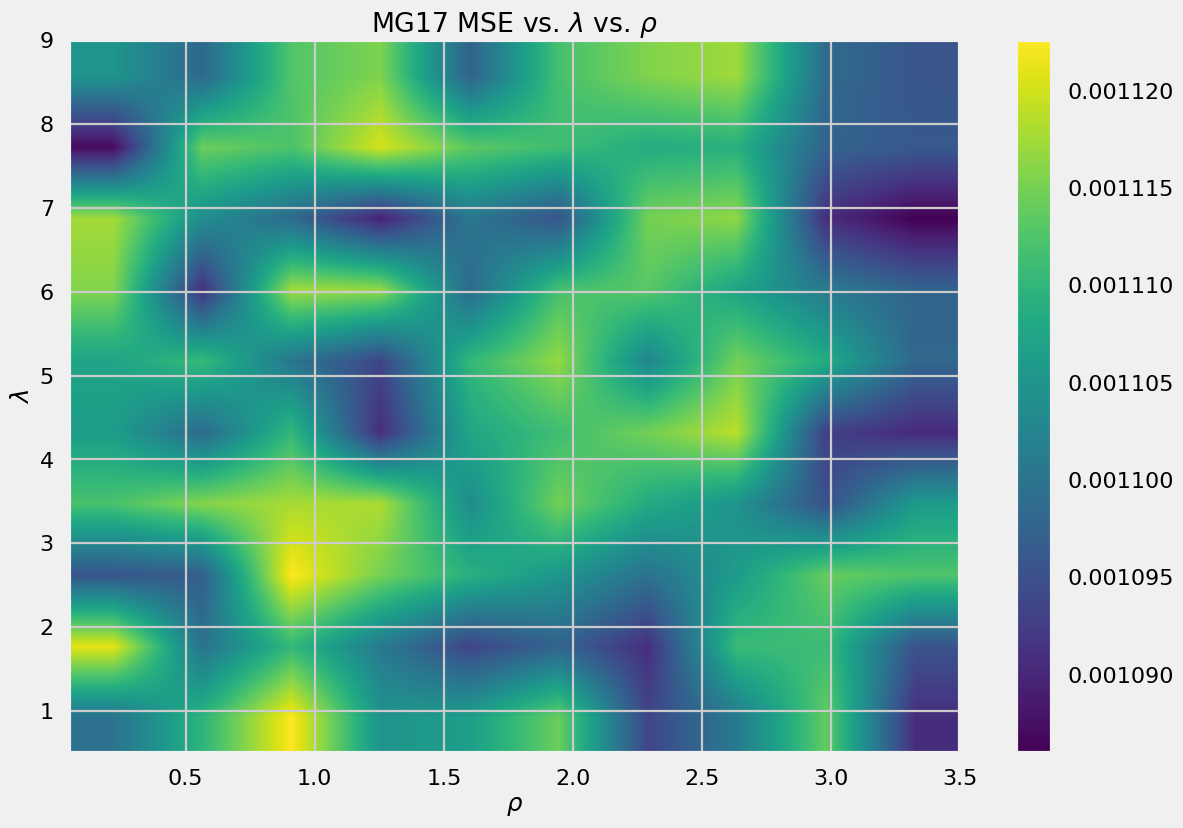

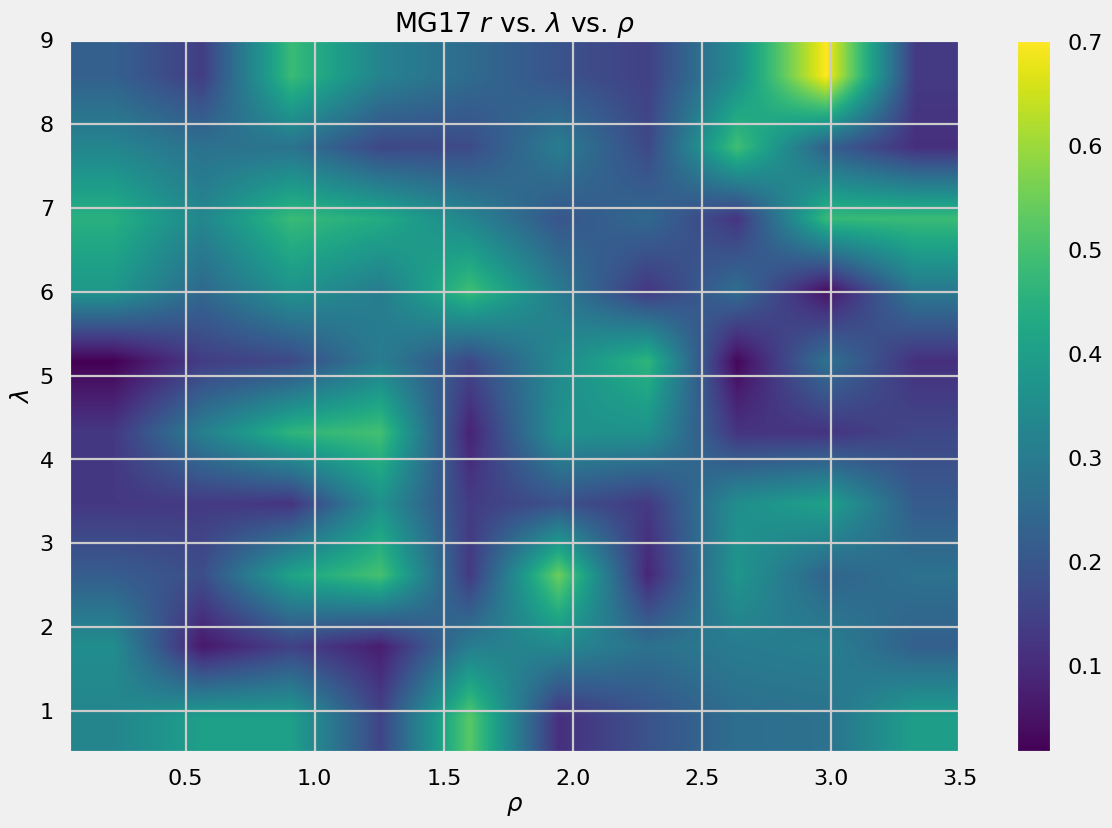

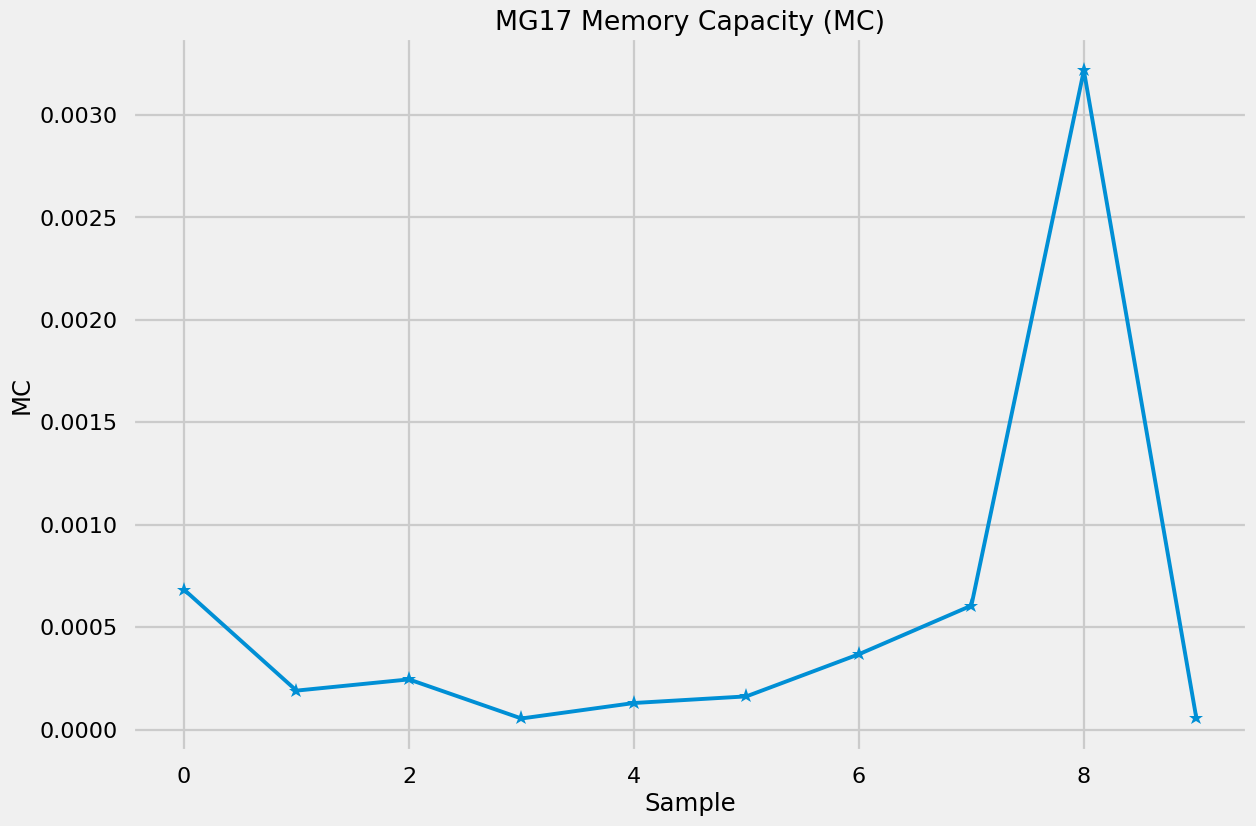

In [82]:
# Define the range of rho and L values to use
rhos = np.linspace(0.05, 3.5, 10)
Ls = np.linspace(0.5, 9, 10)

sparsity = 0.95

# Define the number of iterations to use
num_iterations = 1

# Initialize arrays to store the average MSE values
mse_values = np.zeros((len(rhos), len(Ls)))
r_values = np.zeros((len(rhos), len(Ls)))
mc_values = []

n = 3900
a = 100
b = 2900

N = 10

sparsity = 0.05

# Loop over all combinations of rho and L values
for i, rho in enumerate(rhos):
    for j, L in enumerate(Ls):
        
        # Initialize the mean squared error to zero
        mse = 0
        r = 0
        
        # Perform multiple iterations and average the results
        for k in range(num_iterations):

            print(i, j, k)
            
            # Initialize the input sequence and network parameters
            U = MGSystem(n)
            K = generate_K_matrix(N, rho, sparsity)
            W = generate_W_matrix(N)
            THETA = np.zeros((N, n))
            
            # Train the network and compute the mean squared error
            Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
            mse += MSE(U[b + 1:], Y)
            r += kuramoto_synchrony(THETA[:, -1])
        
        mse /= num_iterations
        print('MSE:', mse)
        r /= num_iterations
        print('r:', r)

        # Store the mean squared error in the array
        mse_values[i, j] = mse
        r_values[i, j] = r
    
    mc = memory_capacity(Y)
    mc_values.append(mc)

# Create a contour plot of the average error as a function of rho and L
X, Y = np.meshgrid(rhos, Ls)
plt.imshow(mse_values.T, extent=[np.min(rhos), np.max(rhos), np.min(Ls), np.max(Ls)], origin='lower', aspect='auto', interpolation='bilinear')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\lambda$')
plt.title(r'MG17 MSE vs. $\lambda$ vs. $\rho$')
plt.colorbar()
plt.show()

X, Y = np.meshgrid(rhos, Ls)
plt.imshow(r_values.T, extent=[np.min(rhos), np.max(rhos), np.min(Ls), np.max(Ls)], origin='lower', aspect='auto', interpolation='bilinear')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\lambda$')
plt.title(r'MG17 $r$ vs. $\lambda$ vs. $\rho$')
plt.colorbar()
plt.show()

plt.plot(range(10), mc_values, '*-')
plt.xlabel('Sample')
plt.ylabel('MC')
plt.title('MG17 Memory Capacity (MC)')
plt.show()

## Variación de radio espectral y fuerza de acoplamiento para MSO12

0 0 0


<ipython-input-36-86a2a31f90df>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y = np.sum(np.sin(2 * np.pi * frequencies[i] * t) for i in range(12))


MSE: 3.874303862358138e-06
r: 0.0956495138077759
0 1 0
MSE: 3.8846370709699985e-06
r: 0.5401913516940724
0 2 0
MSE: 3.898829522922249e-06
r: 0.2853877725954286
0 3 0
MSE: 3.882051867383131e-06
r: 0.3204676297256113
0 4 0
MSE: 3.877986957407237e-06
r: 0.26025110781611194
0 5 0
MSE: 3.848480076134974e-06
r: 0.33115493971809673
0 6 0
MSE: 3.800823287767282e-06
r: 0.21309024797019768
0 7 0
MSE: 3.830914981764864e-06
r: 0.3087171835033785
0 8 0
MSE: 4.120613373601115e-06
r: 0.5008950907167038
0 9 0
MSE: 3.835677123816393e-06
r: 0.3349576878390484
1 0 0
MSE: 3.977218071268571e-06
r: 0.4702887642060588
1 1 0
MSE: 3.829688021590939e-06
r: 0.5142494987627231
1 2 0
MSE: 3.878349610506697e-06
r: 0.23061980953567968
1 3 0
MSE: 3.919546555066125e-06
r: 0.5113198095786202
1 4 0
MSE: 4.440005608097454e-06
r: 0.20581495289075216
1 5 0
MSE: 3.712195704090526e-06
r: 0.12751525875911315
1 6 0
MSE: 5.679070334823294e-06
r: 0.4589794035646002
1 7 0
MSE: 4.919080775111614e-06
r: 0.3910430674600968
1 8 0
MSE

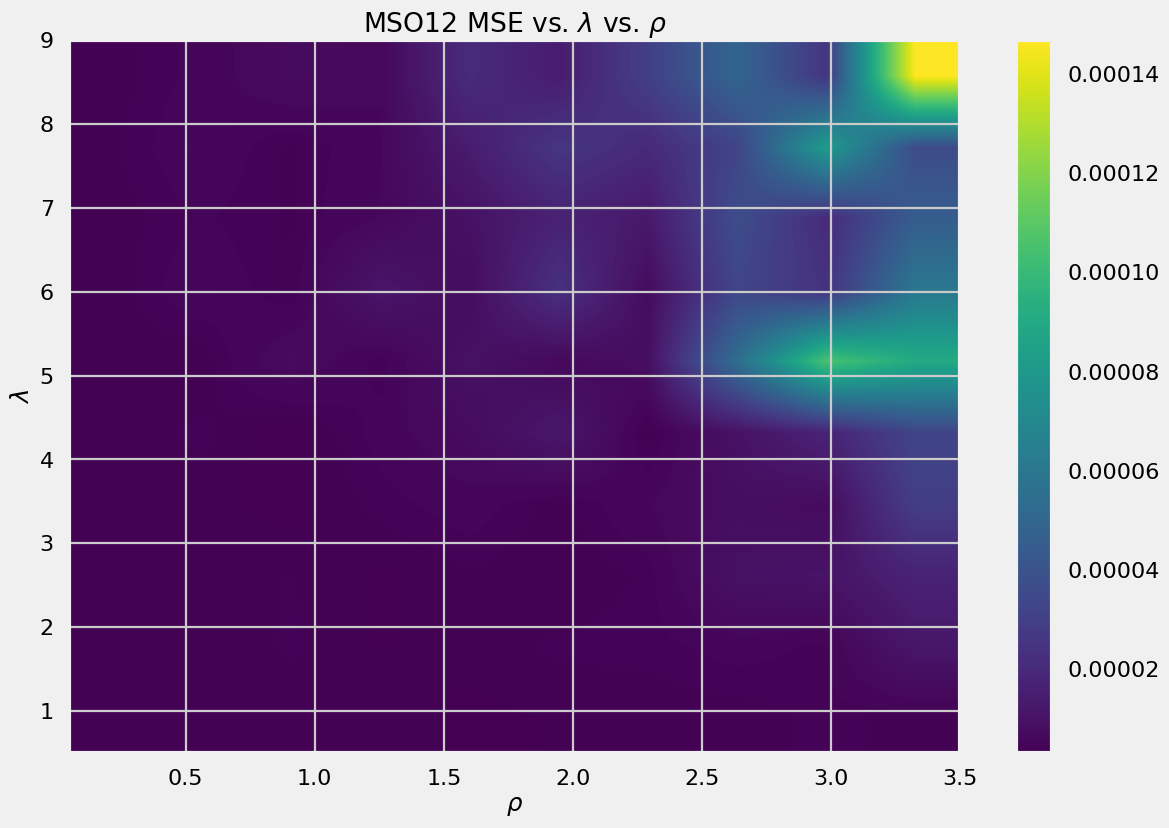

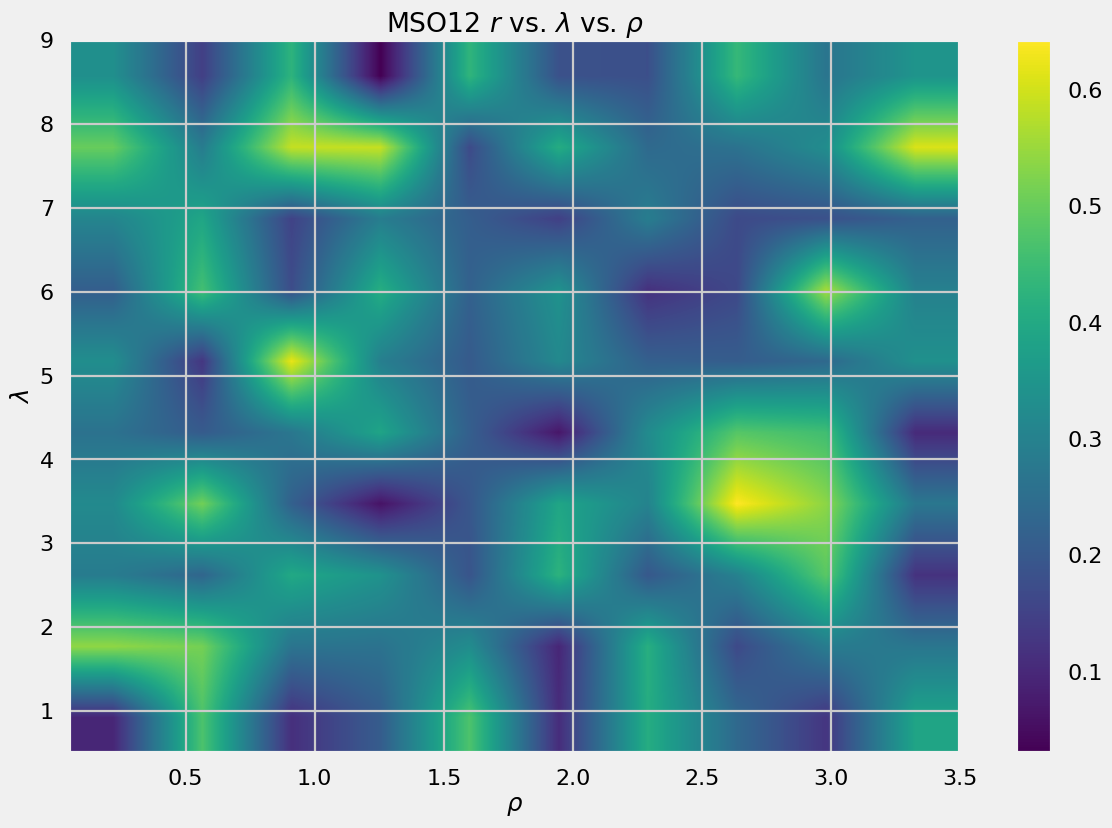

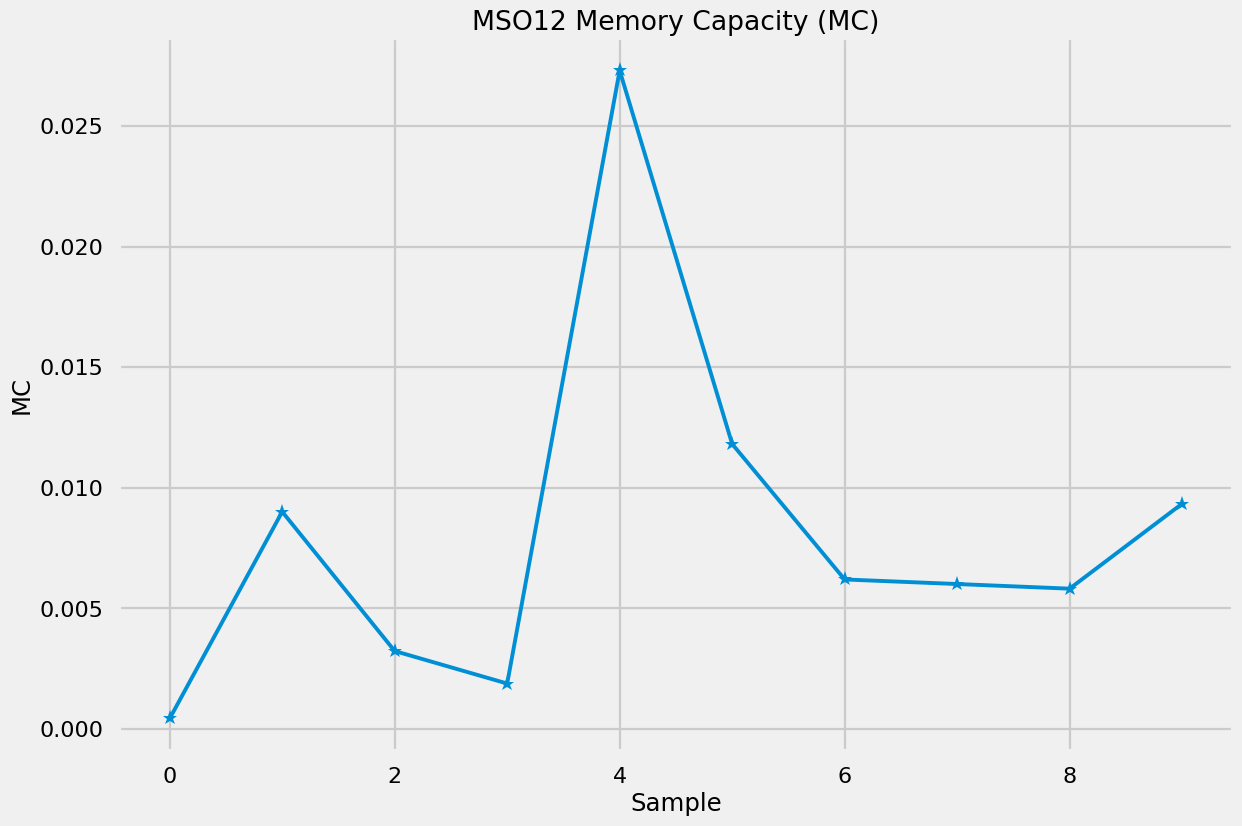

In [95]:
# Define the range of rho and L values to use
rhos = np.linspace(0.05, 3.5, 10)
Ls = np.linspace(0.5, 9, 10)

sparsity = 0.95

# Define the number of iterations to use
num_iterations = 1

# Initialize arrays to store the average MSE values
mse_values = np.zeros((len(rhos), len(Ls)))
r_values = np.zeros((len(rhos), len(Ls)))
mc_values = []

n = 1300
a = 100
b = 1200

N = 10

sparsity = 0.05

# Loop over all combinations of rho and L values
for i, rho in enumerate(rhos):
    for j, L in enumerate(Ls):
        
        # Initialize the mean squared error to zero
        mse = 0
        r = 0
        
        # Perform multiple iterations and average the results
        for k in range(num_iterations):

            print(i, j, k)
            
            # Initialize the input sequence and network parameters
            U = mso12(n)
            K = generate_K_matrix(N, rho, sparsity)
            W = generate_W_matrix(N)
            THETA = np.zeros((N, n))
            
            # Train the network and compute the mean squared error
            Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
            mse += MSE(U[b + 1:-1], Y[1:])
            r += kuramoto_synchrony(THETA[:, -1])
        
        mse /= num_iterations
        print('MSE:', mse)
        r /= num_iterations
        print('r:', r)

        # Store the mean squared error in the array
        mse_values[i, j] = mse
        r_values[i, j] = r
    
    mc = memory_capacity(Y)
    mc_values.append(mc)

# Create a contour plot of the average error as a function of rho and L
X, Y = np.meshgrid(rhos, Ls)
plt.imshow(mse_values.T, extent=[np.min(rhos), np.max(rhos), np.min(Ls), np.max(Ls)], origin='lower', aspect='auto', interpolation='bilinear')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\lambda$')
plt.title(r'MSO12 MSE vs. $\lambda$ vs. $\rho$')
plt.colorbar()
plt.show()

X, Y = np.meshgrid(rhos, Ls)
plt.imshow(r_values.T, extent=[np.min(rhos), np.max(rhos), np.min(Ls), np.max(Ls)], origin='lower', aspect='auto', interpolation='bilinear')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\lambda$')
plt.title(r'MSO12 $r$ vs. $\lambda$ vs. $\rho$')
plt.colorbar()
plt.show()

plt.plot(range(10), mc_values, '*-')
plt.xlabel('Sample')
plt.ylabel('MC')
plt.title('MSO12 Memory Capacity (MC)')
plt.show()

## Variación de la dispersión de la matriz $K$ para NARMA10

0 0
0.009427821126919662
0.4555358846028212
1 0
0.009188769252244242
0.19411792891672852
2 0
0.009088079000361477
0.3635129191370495
3 0
0.008930457604050146
0.2759873799805775
4 0
0.008286387802858617
0.25158768978884083
5 0
0.00854546587415569
0.3604852105956667
6 0
0.007658480105757762
0.47432558065313735
7 0
0.00942514525691666
0.21337863204472474
8 0
0.00927067974198779
0.2285856011382873
9 0
0.009525326056143963
0.19166575341438563
10 0
0.009987311993590407
0.5877620373516876
11 0
0.00948438241784675
0.34819234626863244
12 0
0.009884818707986447
0.1434968132768047
13 0
0.009481747898034274
0.27394284325116847
14 0
0.009642317952099527
0.24624458152389686
15 0
0.010538052608973005
0.12157166390102062
16 0
0.00972093954784147
0.18351743894504832
17 0
0.00793056016924036
0.45472426008656336
18 0
0.008703659268443471
0.632946511283939
19 0
0.009305731175811528
0.13295269125202613
20 0
0.008805140386488471
0.13366746714561262
21 0
0.008074207218506182
0.3527070635104328
22 0
0.0099543

<ipython-input-36-86a2a31f90df>:7: RuntimeWarning: overflow encountered in double_scalars
  0.05 * y[t] * np.sum(y[t - 10 : t]) + \
<ipython-input-56-0ead2dad1d25>:7: RuntimeWarning: invalid value encountered in sin
  val = W[i] + L * sum(K[i][j] * np.sin(THETA[j] - THETA[i] + U[int(T)]) for j in range(N))


nan
nan
46 0
0.009447331031139842
0.46732644754917685
47 0
0.009094933271398068
0.27274753609820046
48 0
0.008868064174522149
0.22303762535241148
49 0
0.010116061446883581
0.1625808146093075
50 0
0.008980887517227013
0.10368634537754683
51 0
0.010268090490667703
0.5521032395010488
52 0
0.008903604789041838
0.5103380843396175
53 0
0.009300141842701183
0.09520674960742044
54 0
0.009110842617256119
0.31978530628795254
55 0
0.00921537422958062
0.22810599802518491
56 0
0.009350351938286218
0.24158909580930618
57 0
0.008167810471200214
0.13932983751315664
58 0
0.009216033829780755
0.13334783396971675
59 0
0.008562838087947338
0.45666504513999345
60 0
0.00842528586717468
0.2060341749364533
61 0
0.009228249952130719
0.2772416322129276
62 0
0.009652150793923012
0.11044294444781699
63 0
0.00859865624821736
0.3446866223947609
64 0
0.008451522428206031
0.26596528871088454
65 0
0.008756391717548698
0.5373109957236484
66 0
0.00942733818909448
0.38197412465619396
67 0
0.009240985649783711
0.361137433

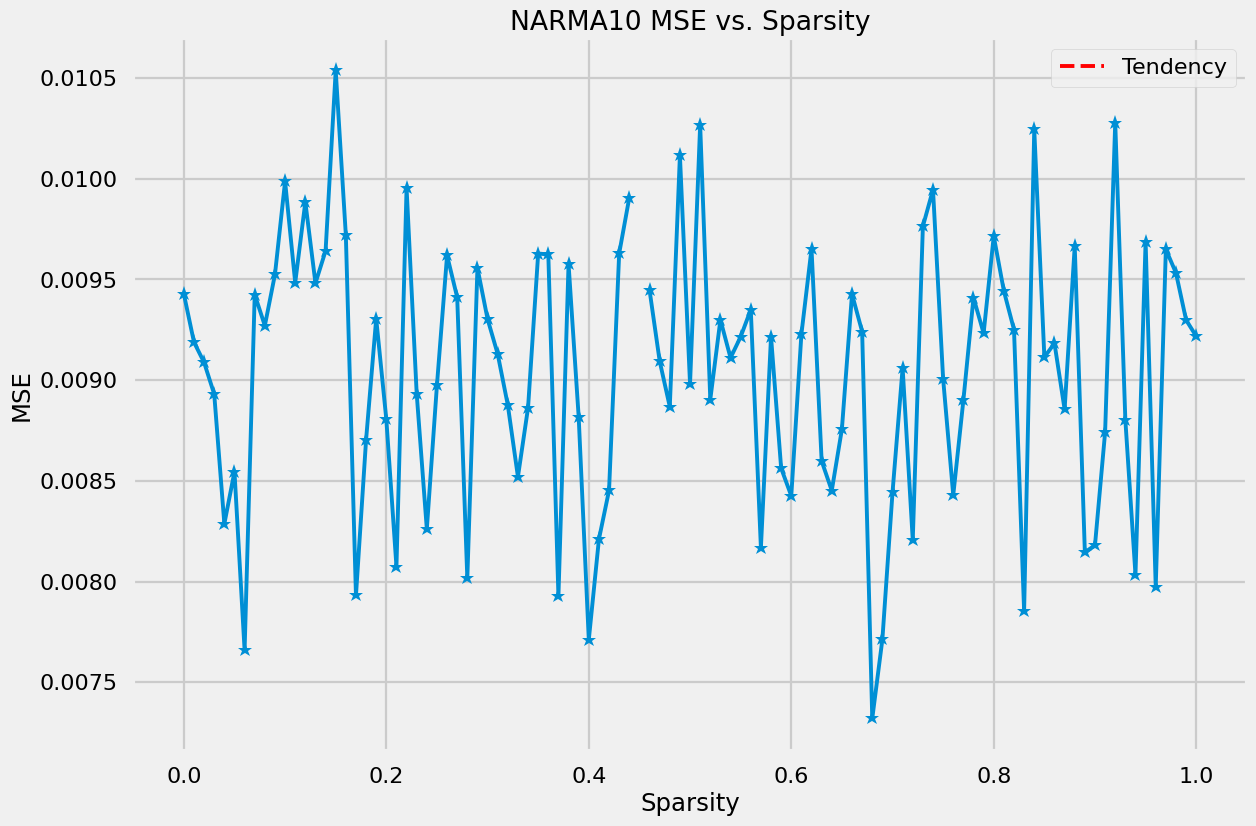

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of sparsity values to use
sparsity_values = np.arange(0, 1.01, 0.01)

# Set the fixed values for rho and L
rho = 2.0
L = 4.0

n = 1400
a = 100
b = 900
N = 10

# Initialize arrays to store the average MSE and r values
mse_values = np.zeros(len(sparsity_values))
r_values = np.zeros(len(sparsity_values))

# Loop over sparsity values
for i, sparsity in enumerate(sparsity_values):
    # Initialize the mean squared error and r values
    mse = 0
    r = 0

    # Perform multiple iterations and average the results
    for k in range(num_iterations):
        print(i, k)

        # Initialize the input sequence and network parameters
        U = narma10(n)
        K = generate_K_matrix(N, rho, sparsity)
        THETA = np.zeros((N, n))
        W = generate_W_matrix(N)

        # Train the network and compute the mean squared error
        Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
        mse += MSE(U[b + 1:], Y)
        r += kuramoto_synchrony(THETA[:, -1])

    mse /= num_iterations
    print(mse)
    r /= num_iterations
    print(r)

    # Store the mean squared error and r values
    mse_values[i] = mse
    r_values[i] = r

# Plot MSE vs. sparsity
plt.plot(sparsity_values, mse_values, '*-')
plt.xlabel('Sparsity')
plt.ylabel('MSE')
plt.title('NARMA10 MSE vs. Sparsity')

# Fit a polynomial line (degree 1) to the data points
tendency = np.polyfit(sparsity_values, mse_values, 1)
tendency_line = np.poly1d(tendency)
plt.plot(sparsity_values, tendency_line(sparsity_values), '--', color='red', label='Tendency')

plt.legend()

plt.show()


## Variación de la dispersión de la matriz $K$ para MG17

0 0
0.0011059150068966671
0.32359022611376437
1 0
0.0011077273382906888
0.0925659024971863
2 0
0.0010956060683449884
0.3992229423693027
3 0
0.001092039925947614
0.03689862699872151
4 0
0.0011142557108742004
0.277377010437476
5 0
0.0010979480857348138
0.0033428660927798375
6 0
0.0011153879409185358
0.3723906262248079
7 0
0.0010920545858545002
0.4322633537832357
8 0
0.001110605865004746
0.4754069539443189
9 0
0.001100008078895398
0.20422327411639382
10 0
0.0011086423382206559
0.46940139790843843
11 0
0.0011196354169334885
0.5056216348836585
12 0
0.0011165299579812453
0.6479417232112646
13 0
0.001101159634895867
0.17896855525789485
14 0
0.001098719349630882
0.38326917675333033
15 0
0.0011213522546618792
0.4435407454874993
16 0
0.0011012018200616254
0.4226667604461605
17 0
0.0010963010791075402
0.097374624890727
18 0
0.0011087520480352836
0.26973048316752446
19 0
0.001118966410797783
0.07103711568459635
20 0
0.0011082348963804645
0.25967701923414815
21 0
0.0010932950752389299
0.13610677616

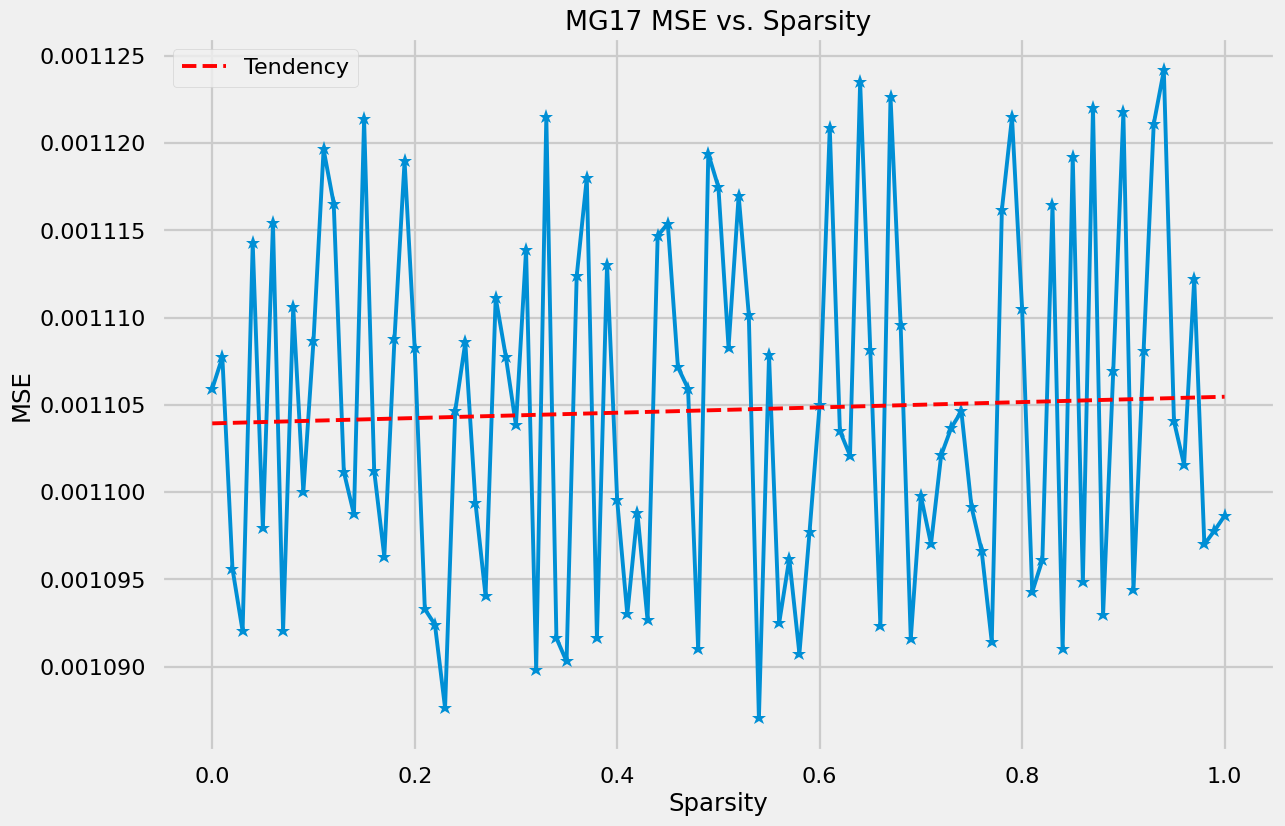

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of sparsity values to use
sparsity_values = np.arange(0, 1.01, 0.01)

# Set the fixed values for rho and L
rho = 2.0
L = 1.0

n = 3900
a = 100
b = 2900
N = 10

# Initialize arrays to store the average MSE and r values
mse_values = np.zeros(len(sparsity_values))
r_values = np.zeros(len(sparsity_values))

# Loop over sparsity values
for i, sparsity in enumerate(sparsity_values):
    # Initialize the mean squared error and r values
    mse = 0
    r = 0

    # Perform multiple iterations and average the results
    for k in range(num_iterations):
        print(i, k)

        # Initialize the input sequence and network parameters
        U = MGSystem(n)
        K = generate_K_matrix(N, rho, sparsity)
        THETA = np.zeros((N, n))
        W = generate_W_matrix(N)

        # Train the network and compute the mean squared error
        Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
        mse += MSE(U[b + 1:], Y)
        r += kuramoto_synchrony(THETA[:, -1])

    mse /= num_iterations
    print(mse)
    r /= num_iterations
    print(r)

    # Store the mean squared error and r values
    mse_values[i] = mse
    r_values[i] = r

# Plot MSE vs. sparsity
plt.plot(sparsity_values, mse_values, '*-')
plt.xlabel('Sparsity')
plt.ylabel('MSE')
plt.title('MG17 MSE vs. Sparsity')

# Fit a polynomial line (degree 1) to the data points
tendency = np.polyfit(sparsity_values, mse_values, 1)
tendency_line = np.poly1d(tendency)
plt.plot(sparsity_values, tendency_line(sparsity_values), '--', color='red', label='Tendency')

plt.legend()
plt.show()


## Variación de la dispersión de la matriz $K$ para MSO12

0 0


<ipython-input-36-86a2a31f90df>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y = np.sum(np.sin(2 * np.pi * frequencies[i] * t) for i in range(12))


1.3169879172924942e-05
0.019455994087324006
1 0
2.3084659148598053e-05
0.48368097700802953
2 0
9.058735427831176e-06
0.2335603123640459
3 0
1.0826517172911051e-05
0.6015952301801087
4 0
1.0415824278681312e-05
0.29235242496278185
5 0
2.434564147800708e-05
0.44978085941802826
6 0
9.780774749627377e-06
0.3768380004837556
7 0
4.351874673019363e-06
0.3283840435237504
8 0
1.1313809988457207e-05
0.3486727944271325
9 0
6.587887352313524e-06
0.19426326675387212
10 0
1.2435178797112516e-05
0.5014952095755413
11 0
5.58801473835529e-06
0.048919590280365056
12 0
1.9617672077023017e-05
0.09020027416662035
13 0
8.797019774746294e-06
0.6695266028068851
14 0
7.228211055363318e-06
0.11319467590050478
15 0
2.0821639531985623e-05
0.7615919061287567
16 0
7.607145491576943e-06
0.6709381442489109
17 0
1.5572696556648487e-05
0.30858496089699855
18 0
1.125467448882178e-05
0.23439815967256883
19 0
9.813124715439223e-06
0.3944472835247912
20 0
1.3732634222390209e-05
0.3174062936857192
21 0
2.1447240965008102e-05

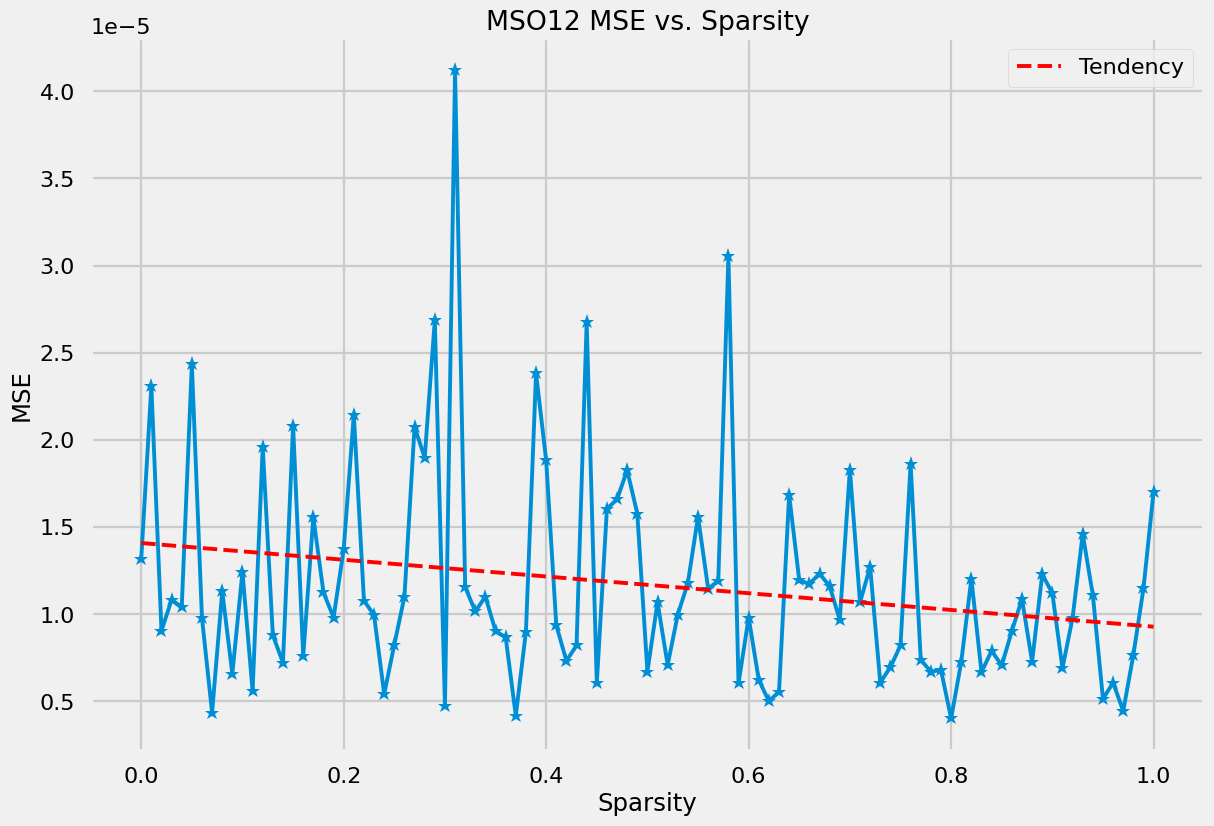

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of sparsity values to use
sparsity_values = np.arange(0, 1.01, 0.01)

# Set the fixed values for rho and L
rho = 2.0
L = 4.0

n = 1300
a = 100
b = 1200
N = 10

# Initialize arrays to store the average MSE and r values
mse_values = np.zeros(len(sparsity_values))
r_values = np.zeros(len(sparsity_values))

# Loop over sparsity values
for i, sparsity in enumerate(sparsity_values):
    # Initialize the mean squared error and r values
    mse = 0
    r = 0

    # Perform multiple iterations and average the results
    for k in range(num_iterations):
        print(i, k)

        # Initialize the input sequence and network parameters
        U = mso12(n)
        K = generate_K_matrix(N, rho, sparsity)
        THETA = np.zeros((N, n))
        W = generate_W_matrix(N)

        # Train the network and compute the mean squared error
        Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
        mse += MSE(U[b + 1:-1], Y[1:])
        r += kuramoto_synchrony(THETA[:, -1])

    mse /= num_iterations
    print(mse)
    r /= num_iterations
    print(r)

    # Store the mean squared error and r values
    mse_values[i] = mse
    r_values[i] = r

# Plot MSE vs. sparsity
plt.plot(sparsity_values, mse_values, '*-')
plt.xlabel('Sparsity')
plt.ylabel('MSE')
plt.title('MSO12 MSE vs. Sparsity')

# Fit a polynomial line (degree 1) to the data points
tendency = np.polyfit(sparsity_values, mse_values, 1)
tendency_line = np.poly1d(tendency)
plt.plot(sparsity_values, tendency_line(sparsity_values), '--', color='red', label='Tendency')

plt.legend()
plt.show()

## Variación de $\beta$ para NARMA10

0 0
0.008772497920211685
0.0857120503413313
1 0
0.008750080303801906
0.5240575527496475
2 0
0.008966014523075189
0.2718898858336491
3 0
0.008158808417724994
0.09480538582597307
4 0
0.01016033321410692
0.4845689896572795
5 0
0.008694001981477541
0.2367129119599283
6 0
0.009392374734535473
0.14226321534138053
7 0
0.008680186108575317
0.15615153946933533
8 0
0.008329391844996729
0.06260250506668427
9 0
0.009007918914289361
0.07430547029309706
10 0
0.008970914838072172
0.49225111415200545
11 0
0.009147232650558126
0.07630213571410357
12 0
0.007906873335512259
0.20126035717701538
13 0
0.00902398866597001
0.5946580007316553
14 0
0.008259727445555342
0.32703725155026314
15 0
0.009236709609002277
0.34524101495782794
16 0
0.00969817378814427
0.27991342342633024
17 0
0.008403579675521126
0.24363586245357083
18 0
0.0078063112972637915
0.06331850037902809
19 0
0.009099951505348461
0.5276710781038552
20 0
0.009907588781608061
0.2657863103299055
21 0
0.00991859691984137
0.335636184793976
22 0
0.0095

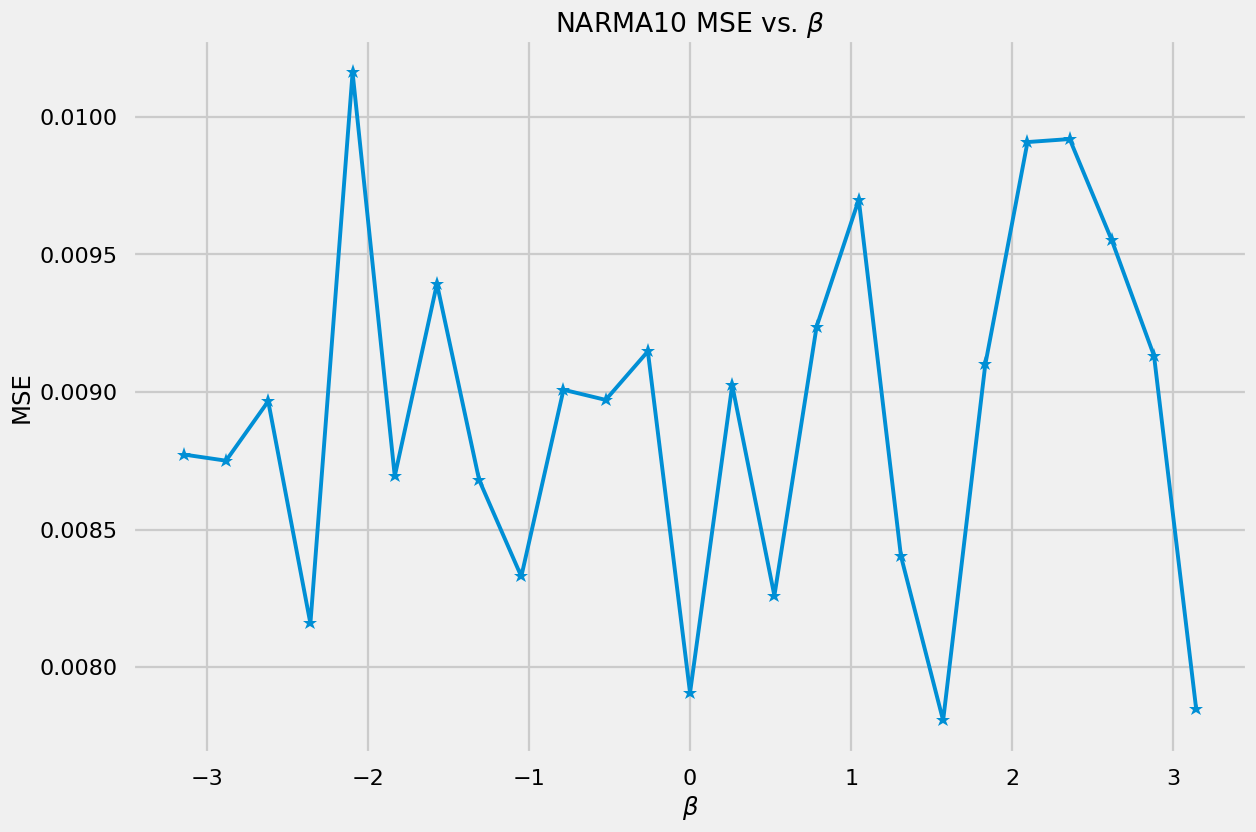

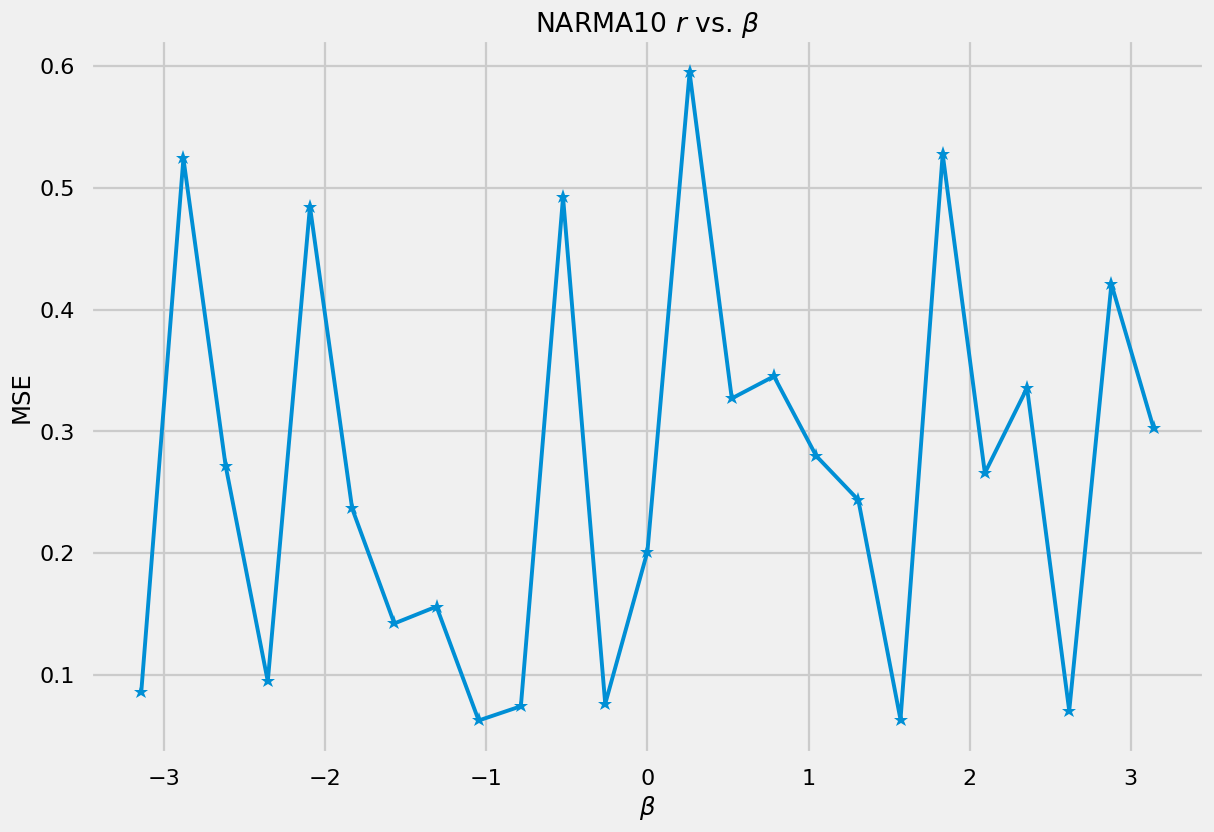

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of sparsity values to use
beta_values = np.arange(-np.pi, np.pi + np.pi/12, np.pi/12)

# Set the fixed values for rho and L
rho = 2.0
L = 4.0

n = 1400
a = 100
b = 900
N = 10

sparsity = 0.95

# Initialize arrays to store the average MSE and r values
mse_values = np.zeros(len(beta_values))
r_values = np.zeros(len(beta_values))

# Loop over sparsity beta_values
for i, B in enumerate(beta_values):
    # Initialize the mean squared error and r values
    mse = 0
    r = 0

    # Perform multiple iterations and average the results
    for k in range(1):
        print(i, k)

        # Initialize the input sequence and network parameters
        U = narma10(n)
        K = generate_K_matrix(N, rho, sparsity)
        THETA = np.zeros((N, n))
        W = generate_W_matrix(N)

        # Train the network and compute the mean squared error
        Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
        mse += MSE(U[b + 1:], Y)
        r += kuramoto_synchrony(THETA[:, -1])

    mse /= num_iterations
    print(mse)
    r /= num_iterations
    print(r)

    # Store the mean squared error and r values
    mse_values[i] = mse
    r_values[i] = r

# Plot MSE vs. beta
plt.plot(beta_values, mse_values, '*-')
plt.xlabel(r'$\beta$')
plt.ylabel('MSE')
plt.title(r'NARMA10 MSE vs. $\beta$')
plt.show()

plt.plot(beta_values, r_values, '*-')
plt.xlabel(r'$\beta$')
plt.ylabel('MSE')
plt.title(r'NARMA10 $r$ vs. $\beta$')
plt.show()


## Ejecución del algoritmo para NARMA10 para tres valores fijos de $\beta$

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of sparsity values to use
beta_values = [-np.pi/2, 0, np.pi/2]

# Set the fixed values for rho and L
rho = 2.0
L = 4.0

n = 1400
a = 100
b = 900
N = 10

sparsity = 0.95

K_init = generate_K_matrix(N, rho, sparsity=sparsity)
developed_K_matrices = []

# Initialize arrays to store the average MSE and r values
mse_values = np.zeros(len(beta_values))
r_values = np.zeros(len(beta_values))

# Loop over sparsity beta_values
for i, B in enumerate(beta_values):
    # Initialize the mean squared error and r values
    mse = 0
    r = 0

    # Perform multiple iterations and average the results
    for k in range(1):
        print(i, k)

        # Initialize the input sequence and network parameters
        U = narma10(n)
        K = K_init.copy()
        THETA = np.zeros((N, n))
        W = generate_W_matrix(N)

        # Train the network and compute the mean squared error
        Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)

        developed_K_matrices.append(K)

        mse += MSE(U[b + 1:], Y)
        r += kuramoto_synchrony(THETA[:, -1])

    mse /= num_iterations
    print(mse)
    r /= num_iterations
    print(r)

    # Store the mean squared error and r values
    mse_values[i] = mse
    r_values[i] = r


0 0
0.008355701588293653
0.2966421288920473
1 0
0.010730747074426828
0.31137071357576807
2 0
0.00834432467175706
0.16501600024350202


## Graficación del reservorio como una red de sinapsis inhibitorias y excitatorias

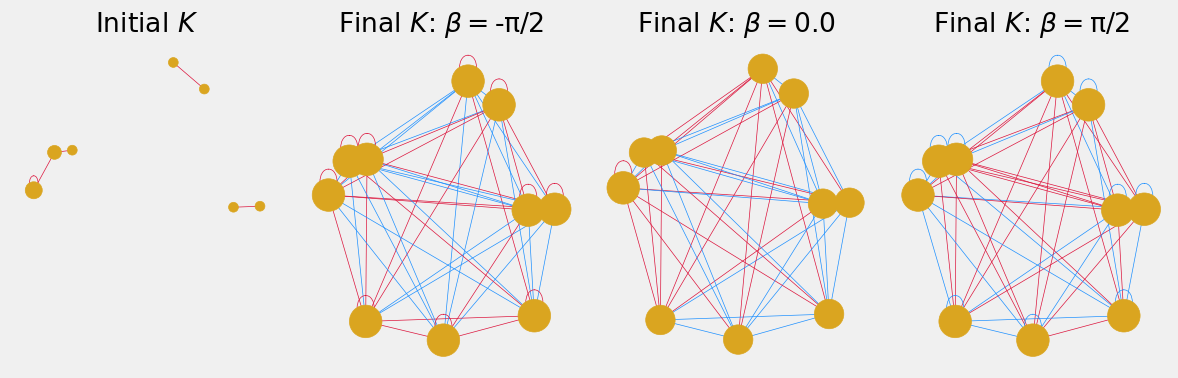

In [120]:
import networkx as nx

# Plotting the graphs
G_init = nx.from_numpy_array(K_init)

# Define a common layout for all graphs
pos = nx.spring_layout(G_init, seed=42)

plt.figure(figsize=(12, 4))
plt.subplot(1, len(developed_K_matrices) + 1, 1)
plt.title(r"Initial $K$")
edge_colors_init = ["crimson" if w > 0 else "dodgerblue" for u, v, w in G_init.edges.data("weight")]
nx.draw_networkx(G_init, pos=pos, node_size=50 * np.array(list(dict(G_init.degree()).values())), edge_color=edge_colors_init, width=0.5, with_labels=False, node_color='goldenrod')
plt.axis("off")

for i, K in enumerate(developed_K_matrices):
    G = nx.from_numpy_array(K)

    plt.subplot(1, len(developed_K_matrices) + 1, i + 2)
    plt.title(r"Final $K$: $\beta=$" + ['-π/2', '0.0', 'π/2'][i])
    edge_colors = ["crimson" if w > 0 else "dodgerblue" for u, v, w in G.edges.data("weight")]
    nx.draw_networkx(G, pos=pos, node_size=50 * np.array(list(dict(G.degree()).values())), edge_color=edge_colors, width=0.5, with_labels=False, node_color='goldenrod')
    plt.axis("off")

plt.tight_layout()
plt.show()
